In [1]:
import infomap
from infomap import Infomap
import pandas as pd
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt 
import pickle as pk

In [2]:
#Let's import the final EEN
final_backbone_exp_graph_significant_combo_df = pd.read_csv("output/final_backbone_exp_graph_significant_combo_ji_df.tsv", sep="\t",index_col=0)
backbone_ss_exposure_network = nx.from_pandas_edgelist(final_backbone_exp_graph_significant_combo_df, 'Exp A', 'Exp B')


In [3]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist 
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass

In [4]:
#from https://mapequation.github.io/infomap/python/infomap.html#infomap.InfomapIterator
#for some more examples on infomap: 
#https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=bd65c716de009b259e33715093fca7d27e06699b&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6368726973626c6f65636b65722f696e666f6d61702d6269706172746974652f626436356337313664653030396232353965333337313530393366636137643237653036363939622f6578616d706c65732f707974686f6e2f696e666f6d61702d6578616d706c65732e6970796e62&logged_in=false&nwo=chrisbloecker%2Finfomap-bipartite&path=examples%2Fpython%2Finfomap-examples.ipynb&platform=android&repository_id=176271675&repository_type=Repository&version=99


im = Infomap(silent=True)
mapping = im.add_networkx_graph(backbone_ss_exposure_network)
im.run()
for modules in sorted(im.get_multilevel_modules().values()):
    print(modules)

(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)


(1, 17, 17)
(1, 17, 17)
(1, 17, 17)
(1, 17, 17)
(1, 17, 17)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 18, 18)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 19, 19)
(1, 

(2, 110, 115)
(2, 110, 115)
(2, 110, 115)
(2, 110, 115)
(2, 110, 115)
(2, 110, 115)
(2, 110, 115)
(2, 110, 115)
(2, 110, 115)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 111, 116)
(2, 11

In [5]:
backbone_node_com_dict={}
for node,modules in im.get_multilevel_modules(states=True).items():
    backbone_node_com_dict[mapping[node]]=list(modules)


In [6]:
tot_com_list=[]
for node,com_list in backbone_node_com_dict.items():
    tot_com_list.extend(com_list)
print(len(set(tot_com_list)))  #This is the total number of communities

backbone_com_node_dict={}
for com in set(tot_com_list):
    node_list=[]
    for node,com_list in backbone_node_com_dict.items():
        if com in com_list:
            node_list.append(node)
    backbone_com_node_dict[com]=node_list
        
for com,node_list in backbone_com_node_dict.items():
    print("In %s there are %s exposures" %(com, len(node_list)))

484
In 1 there are 8097 exposures
In 2 there are 1165 exposures
In 3 there are 691 exposures
In 4 there are 368 exposures
In 5 there are 384 exposures
In 6 there are 275 exposures
In 7 there are 184 exposures
In 8 there are 269 exposures
In 9 there are 186 exposures
In 10 there are 149 exposures
In 11 there are 189 exposures
In 12 there are 131 exposures
In 13 there are 134 exposures
In 14 there are 114 exposures
In 15 there are 87 exposures
In 16 there are 90 exposures
In 17 there are 94 exposures
In 18 there are 66 exposures
In 19 there are 75 exposures
In 20 there are 85 exposures
In 21 there are 61 exposures
In 22 there are 55 exposures
In 23 there are 54 exposures
In 24 there are 64 exposures
In 25 there are 86 exposures
In 26 there are 70 exposures
In 27 there are 56 exposures
In 28 there are 66 exposures
In 29 there are 41 exposures
In 30 there are 45 exposures
In 31 there are 67 exposures
In 32 there are 41 exposures
In 33 there are 51 exposures
In 34 there are 60 exposures
In 

In [7]:
first_iteration_infomap={}
second_iteration_infomap={}
third_iteration_infomap={}
fourth_iteration_infomap={}

for com in set(im.get_modules(depth_level=1).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=1).items():
        if com==com1:
            node_list.append(mapping[node])
    first_iteration_infomap[com]=node_list 
    
    
for com in set(im.get_modules(depth_level=2).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=2).items():
        if com==com1:
            node_list.append(mapping[node])
    second_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=3).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=3).items():
        if com==com1:
            node_list.append(mapping[node])
    third_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=4).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=4).items():
        if com==com1:
            node_list.append(mapping[node])
    fourth_iteration_infomap[com]=node_list

In [8]:
len(first_iteration_infomap)

212

In [9]:
len(second_iteration_infomap)

446

In [10]:
len(third_iteration_infomap)

484

In [13]:
len(fourth_iteration_infomap)

484

In [11]:
for com,node_list in third_iteration_infomap.items():
    print("In %s there are %s exposures" %(com, len(node_list)))

In 1 there are 1277 exposures
In 2 there are 1042 exposures
In 3 there are 578 exposures
In 4 there are 282 exposures
In 5 there are 340 exposures
In 6 there are 227 exposures
In 7 there are 161 exposures
In 8 there are 214 exposures
In 9 there are 148 exposures
In 10 there are 131 exposures
In 11 there are 176 exposures
In 12 there are 120 exposures
In 13 there are 115 exposures
In 14 there are 104 exposures
In 15 there are 78 exposures
In 16 there are 81 exposures
In 17 there are 86 exposures
In 18 there are 58 exposures
In 19 there are 67 exposures
In 20 there are 78 exposures
In 21 there are 54 exposures
In 22 there are 48 exposures
In 23 there are 47 exposures
In 24 there are 58 exposures
In 25 there are 80 exposures
In 26 there are 64 exposures
In 27 there are 50 exposures
In 28 there are 60 exposures
In 29 there are 35 exposures
In 30 there are 39 exposures
In 31 there are 62 exposures
In 32 there are 36 exposures
In 33 there are 32 exposures
In 34 there are 10 exposures
In 35 t

In [12]:
len(set(im.get_modules(depth_level=3).keys()))

9302

In [14]:
with open('output/Communities/Infomap/first_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(first_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/second_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(second_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/third_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(third_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)


In [4]:
import pickle as pk
with open('output/Communities/Infomap/first_iteration_infomap.pickle', 'rb') as handle:
    first_iteration_infomap = pk.load(handle)

with open('output/Communities/Infomap/second_iteration_infomap.pickle', 'rb') as handle:
    second_iteration_infomap = pk.load(handle)

with open('output/Communities/Infomap/third_iteration_infomap.pickle', 'rb') as handle:
    third_iteration_infomap = pk.load(handle)


In [33]:
#These communities are the middle and the broad level related to each community

ee_first_level_infomap={}  #middle to fine
for comcom, explist1 in second_iteration_infomap.items():
    comlist=[]
    for com, explist2 in third_iteration_infomap.items():
        if len(set(explist1)&set(explist2))==len(set(explist2)):
           comlist.append(com)
    ee_first_level_infomap[comcom]=comlist

ee_second_level_infomap={}  #broad to middle
for comcom, explist1 in first_iteration_infomap.items():
    comlist=[]
    for com, explist2 in second_iteration_infomap.items():
        if len(set(explist1)&set(explist2))==len(set(explist2)):
           comlist.append(com)
    ee_second_level_infomap[comcom]=comlist
 

In [36]:
with open('output/Communities/Infomap/ee_ji_first_infomap_iteration.pickle', 'wb') as handle:
    pk.dump(ee_first_level_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/ee_ji_second_infomap_iteration.pickle', 'wb') as handle:
    pk.dump(ee_second_level_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)

In [5]:
#Let's import the 3 hierarchical levels of infomap communities

with open('output/Communities/Infomap/ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    infomap_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    infomap_middle_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    infomap_broad_communities_dict = pk.load(handle)


#Let's import the 3 hierarchical levels of louvain communities

with open('output/Communities/Louvain/ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    louvain_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Louvain/ji_middle_communities_dict.pickle', 'rb') as handle:
    louvain_middle_communities_dict = pk.load(handle)

with open('output/Communities/Louvain/ji_broad_communities_dict.pickle', 'rb') as handle:
    louvain_broad_communities_dict = pk.load(handle)


In [6]:
#Let's compare these communities

#Fine-grained

common_louvain_finegrained_com_list=[]
for com1,explist1 in louvain_fine_grained_communities_dict.items():
    for com2,explist2 in infomap_fine_grained_communities_dict.items():
        if len(set(explist1)&set(explist2))>=0.99*len(explist1):
            if len(set(explist1)&set(explist2))>=0.99*len(explist2):
                common_louvain_finegrained_com_list.append(com1)

#Intermediate
common_louvain_middle_com_list=[]
for com1,explist1 in louvain_middle_communities_dict.items():
    for com2,explist2 in infomap_middle_communities_dict.items():
        if len(set(explist1)&set(explist2))>=0.99*len(explist1):
            if len(set(explist1)&set(explist2))>=0.99*len(explist2):
                common_louvain_middle_com_list.append(com1)

#Broad
common_louvain_broad_com_list=[]
for com1,explist1 in louvain_broad_communities_dict.items():
    for com2,explist2 in infomap_broad_communities_dict.items():
        if len(set(explist1)&set(explist2))>=0.99*len(explist1):
            if len(set(explist1)&set(explist2))>=0.99*len(explist2):
                common_louvain_broad_com_list.append(com1)


In [7]:
len(set(common_louvain_finegrained_com_list))/len(louvain_fine_grained_communities_dict)

0.6026615969581749

In [64]:
len(set(common_louvain_middle_com_list))/len(louvain_middle_communities_dict)

0.2

In [65]:
len(set(common_louvain_broad_com_list))/len(louvain_broad_communities_dict)

0.0

In [11]:
com_source=[]
com_target=[]
value_list=[]
com_label=["Louvain_"+str(com1) for com1 in list(louvain_broad_communities_dict.keys())]+["Infomap_"+str(com2) for com2 in list(infomap_broad_communities_dict.keys())]

for com1,genelist1 in louvain_broad_communities_dict.items():
    for com2,genelist2 in infomap_broad_communities_dict.items():
        com1_name="Louvain_"+str(com1)
        com2_name="Infomap_"+str(com2)
        com_source_index=com_label.index(com1_name)
        com_target_index=com_label.index(com2_name)
        for gene in genelist1:
            if gene in genelist2:
                com_source.append(com_source_index)
                com_target.append(com_target_index)
                value_list.append(1)
        #value_list.append(ov*10000)
        #value_list.append(10)

        


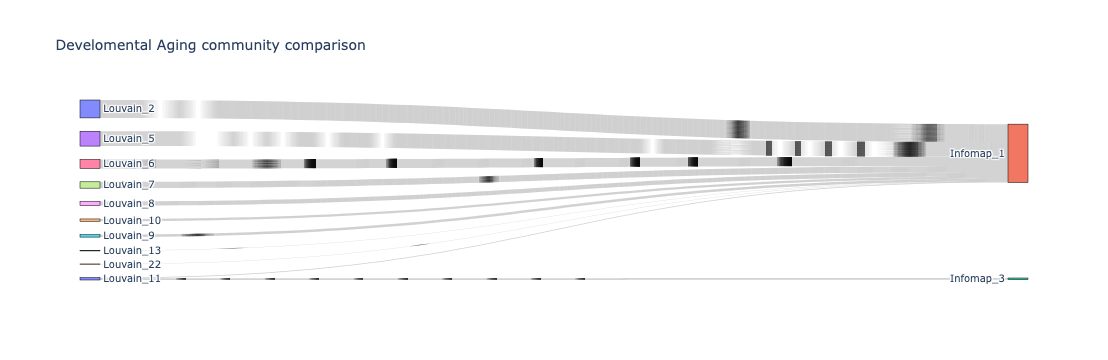

In [12]:
import plotly.graph_objects as go
import kaleido


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = com_label,
    ),
    link = dict(
      source = com_source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = com_target,
      value = value_list,
      line = dict(color = "grey", width = 0.005),
        
  ))])
fig.update_layout(title_text="Community comparison", font_size=10)
fig.show()

In [66]:
set(common_louvain_finegrained_com_list)

{'100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '10_1_2',
 '10_1_6',
 '10_1_7',
 '10_1_9',
 '10_2_1',
 '10_2_2',
 '10_2_3',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '11_1_1',
 '11_1_2',
 '11_1_3',
 '11_1_4',
 '11_1_5',
 '11_2_1',
 '11_3_2',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '13_1_2',
 '13_1_3',
 '13_1_4',
 '13_2_1',
 '13_2_2',
 '13_2_3',
 '13_2_4',
 '13_3_1',
 '13_3_2',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '14_1_1',
 '14_1_2',
 '14_1_3',
 '14_1_4',
 '14_2_1',
 '14_2_2',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '15_2',
 '15_3',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 

In [67]:
louvain_fine_grained_communities_dict

{'97': ['D008729', 'C099495', 'C071739'],
 '9_1_4': ['C042743', 'D000069447', 'D014331', 'C042375'],
 '20_1': ['C022776',
  'D003486',
  'C081906',
  'C516077',
  'C054619',
  'C009694',
  'C025257',
  'C023622',
  'C021758',
  'C018691',
  'C004521',
  'C031392',
  'C008628',
  'C029369',
  'C045271',
  'C056014',
  'C000600849',
  'C029370',
  'C034674',
  'C014949',
  'C006712',
  'C006991',
  'C034451',
  'C051715',
  'D006219',
  'C006377',
  'C548400',
  'D011190',
  'D012973',
  'C034193'],
 '11_1_4': ['D011431',
  'C122128',
  'C119971',
  'C118008',
  'C418208',
  'C010847',
  'C036466',
  'D008614',
  'C576198',
  'C518978',
  'C412047'],
 '88': ['D001398', 'D002506', 'D002937'],
 '5_1_4': ['C006737',
  'D002164',
  'C040083',
  'C026386',
  'C091518',
  'C490166',
  'D001534',
  'D001640',
  'C015044',
  'C021604',
  'D000078328',
  'C049853',
  'C019466',
  'C400939',
  'C031503',
  'D010852',
  'C022961',
  'C085794',
  'D002328',
  'C022871',
  'D005045',
  'D007811',
  '

In [69]:
for com,explist in infomap_fine_grained_communities_dict.items():
    if explist==louvain_fine_grained_communities_dict['10_2_2']:
        print(com)

1_170


In [72]:
fine_grained_communities_community_size=[]
middle_communities_community_size=[]
broad_communities_community_size=[]

for com,explist in infomap_fine_grained_communities_dict.items():
    fine_grained_communities_community_size.append(len(explist))
    

for com,explist in infomap_middle_communities_dict.items():
    middle_communities_community_size.append(len(explist))
    
for com,explist in infomap_broad_communities_dict.items():
    broad_communities_community_size.append(len(explist))
    

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/926073339.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Infomap Iteration", y="Exposure size", data=EEN_infomap_com_df, estimator=np.mean,
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/926073339.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/926073339.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


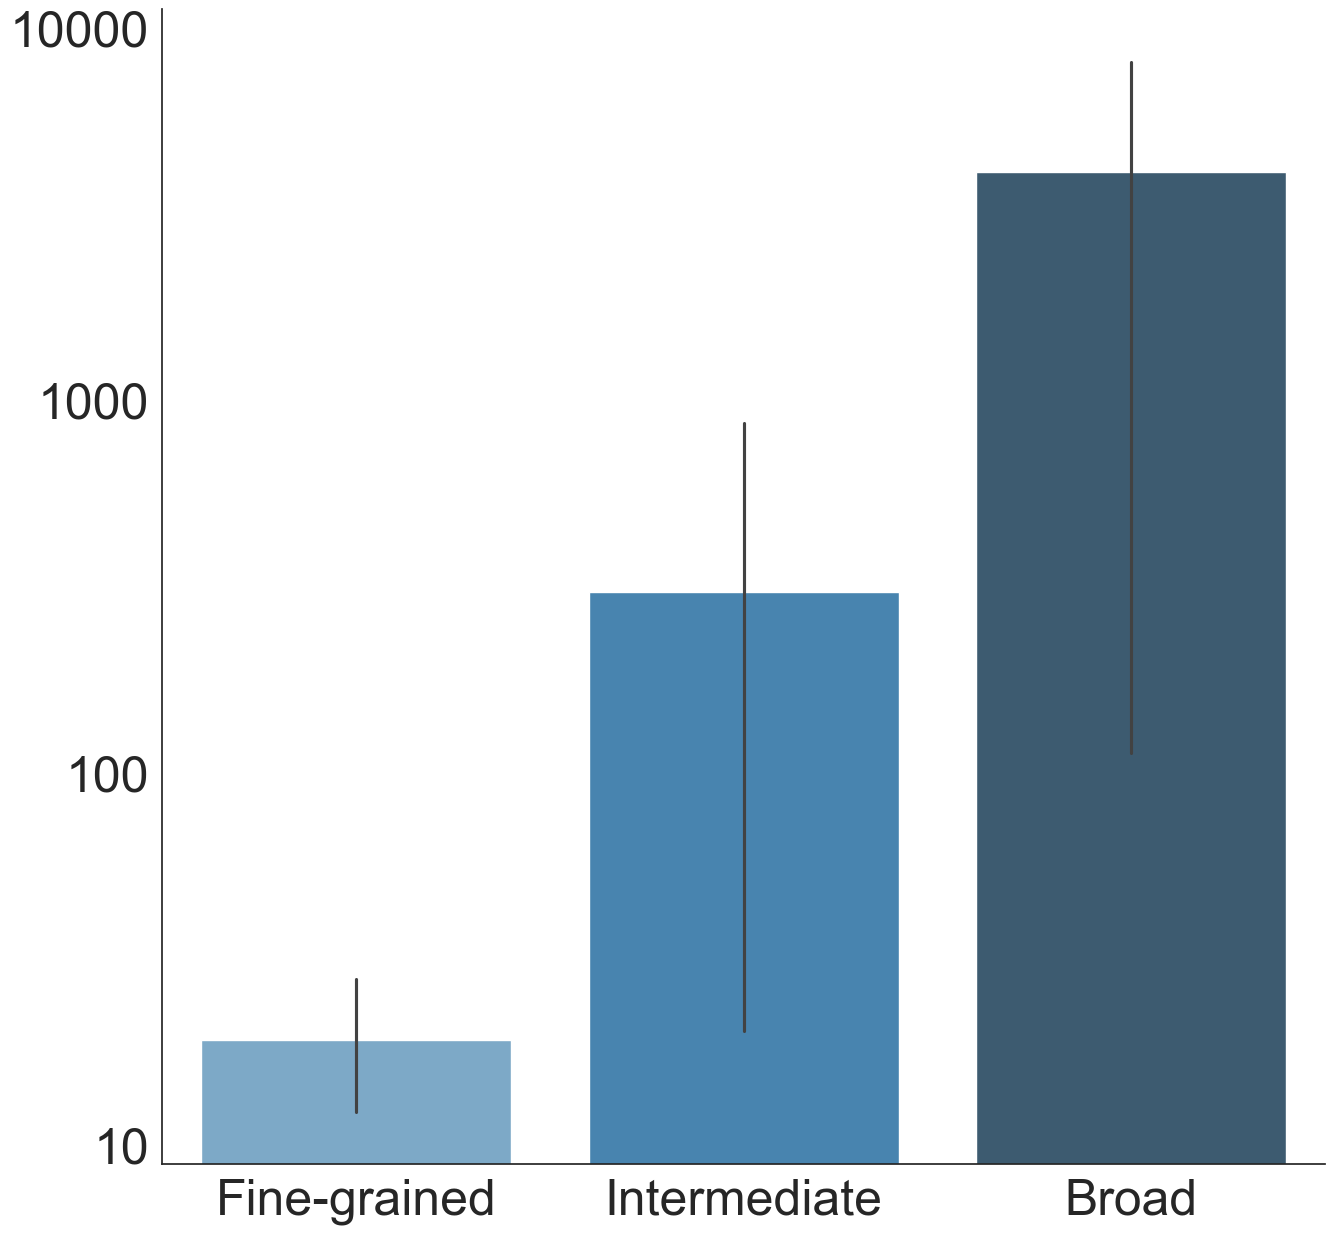

In [76]:
column_names = ["Exposure size", "infomap Iteration"]
labels=['Fine-grained','Intermediate','Broad']
exposuresize_list_tot=[]
group_list=[]
for i in fine_grained_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Fine-grained")
    
for i in middle_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Intermediate")

for i in broad_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Broad")
    
EEN_infomap_com_df = pd.DataFrame(columns = column_names)
EEN_infomap_com_df["Exposure size"]=exposuresize_list_tot
EEN_infomap_com_df["Infomap Iteration"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")


ax = sns.barplot(x="Infomap Iteration", y="Exposure size", data=EEN_infomap_com_df, estimator=np.mean,
                 palette="Blues_d")

ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
plt.yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
plt.savefig('output/Figures/SF17A_v00.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [77]:
#Here, we import the results that have been calculated in the cluster
    
with open('output/Communities/Infomap/ji_lead_genes_kegg_fine_grained_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    fine_grained_communities_kegg = pk.load(handle)   
with open('output/Communities/Infomap/ji_lead_genes_kegg_middle_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    middle_communities_kegg = pk.load(handle)       
with open('output/Communities/Infomap/ji_lead_genes_kegg_broad_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    broad_communities_kegg = pk.load(handle)       
    
with open('output/Communities/Infomap/ji_lead_genes_gobp_fine_grained_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    fine_grained_communities_gobp = pk.load(handle)   
with open('output/Communities/Infomap/ji_lead_genes_gobp_middle_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    middle_communities_gobp = pk.load(handle)       
with open('output/Communities/Infomap/ji_lead_genes_gobp_broad_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    broad_communities_gobp = pk.load(handle)  
    
with open('output/Communities/Infomap/ji_lead_genes_gomf_fine_grained_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    fine_grained_communities_gomf = pk.load(handle)   
with open('output/Communities/Infomap/ji_lead_genes_gomf_middle_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    middle_communities_gomf = pk.load(handle)       
with open('output/Communities/Infomap/ji_lead_genes_gomf_broad_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    broad_communities_gomf = pk.load(handle)  
    
with open('output/Communities/Infomap/ji_lead_genes_gocc_fine_grained_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    fine_grained_communities_gocc = pk.load(handle)   
with open('output/Communities/Infomap/ji_lead_genes_gocc_middle_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    middle_communities_gocc = pk.load(handle)       
with open('output/Communities/Infomap/ji_lead_genes_gocc_broad_infomap_cluster_significant_fdr.pickle', 'rb') as handle:
    broad_communities_gocc = pk.load(handle)  
    


In [78]:
#Let's collect the number of associated enriched terms

fine_grained_communities_gobp_len=[]
for com,term_list in fine_grained_communities_gobp.items():
    if type(term_list[1])!=str:
        fine_grained_communities_gobp_len.append(len(term_list[1]))

fine_grained_communities_gomf_len=[]
for com,term_list in fine_grained_communities_gomf.items():
    if type(term_list[1])!=str:
        fine_grained_communities_gomf_len.append(len(term_list[1]))
    
fine_grained_communities_gocc_len=[]
for com,term_list in fine_grained_communities_gocc.items():
    if type(term_list[1])!=str:
        fine_grained_communities_gocc_len.append(len(term_list[1]))
    
fine_grained_communities_kegg_len=[]
for com,term_list in fine_grained_communities_kegg.items():
    if type(term_list[1])!=str:
        fine_grained_communities_kegg_len.append(len(term_list[1]))

middle_communities_gobp_len=[]
for com,term_list in middle_communities_gobp.items():
    if type(term_list[1])!=str:
        middle_communities_gobp_len.append(len(term_list[1]))

middle_communities_gomf_len=[]
for com,term_list in middle_communities_gomf.items():
    if type(term_list[1])!=str:
        middle_communities_gomf_len.append(len(term_list[1]))
    
middle_communities_gocc_len=[]
for com,term_list in middle_communities_gocc.items():
    if type(term_list[1])!=str:
        middle_communities_gocc_len.append(len(term_list[1]))
    
middle_communities_kegg_len=[]
for com,term_list in middle_communities_kegg.items():
    if type(term_list[1])!=str:
        middle_communities_kegg_len.append(len(term_list[1]))
    
broad_communities_gobp_len=[]
for com,term_list in broad_communities_gobp.items():
    if type(term_list[1])!=str:
        broad_communities_gobp_len.append(len(term_list[1]))

broad_communities_gomf_len=[]
for com,term_list in broad_communities_gomf.items():
    if type(term_list[1])!=str:
        broad_communities_gomf_len.append(len(term_list[1]))
    
broad_communities_gocc_len=[]
for com,term_list in broad_communities_gocc.items():
    if type(term_list[1])!=str:
        broad_communities_gocc_len.append(len(term_list[1]))

broad_communities_kegg_len=[]
for com,term_list in broad_communities_kegg.items():
    if type(term_list[1])!=str:
        broad_communities_kegg_len.append(len(term_list[1]))

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/1584830892.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size = 36)


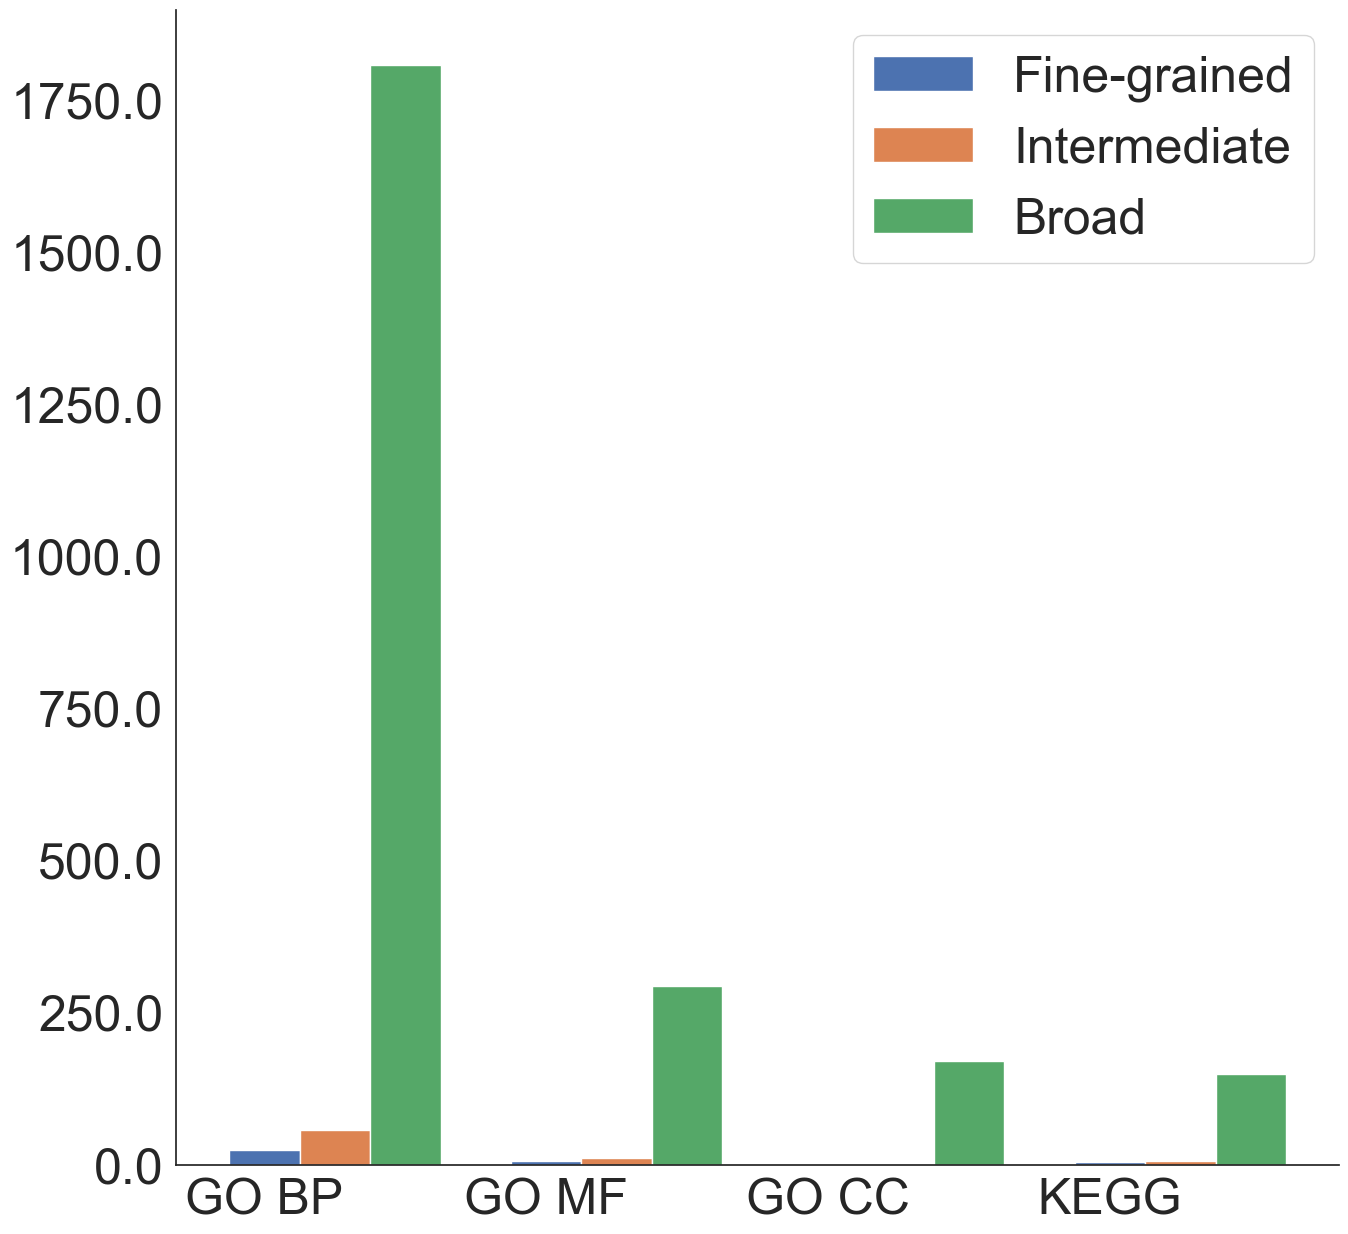

In [79]:
#Let's calculate the amount of terms that we have found for each GO enrichment
X = ['GO BP','GO MF','GO CC','KEGG']

finegrained_iteration = [np.median(fine_grained_communities_gobp_len),np.median(fine_grained_communities_gomf_len),
                  np.median(fine_grained_communities_gocc_len),np.median(fine_grained_communities_kegg_len)]
middle_iteration = [np.median(middle_communities_gobp_len),np.median(middle_communities_gomf_len),
                  np.median(middle_communities_gocc_len),np.median(middle_communities_kegg_len)]
broad_iteration = [np.median(broad_communities_gobp_len),np.median(broad_communities_gomf_len),
                  np.median(broad_communities_gocc_len),np.median(broad_communities_kegg_len)]

fig, ax = plt.subplots(figsize=(15, 15))
X_axis = np.arange(len(X))
  
plt.bar(X_axis, finegrained_iteration, 0.25, label = 'Fine-grained')
plt.bar(X_axis +0.25, middle_iteration, 0.25, label = 'Intermediate')
plt.bar(X_axis + 0.5, broad_iteration, 0.25, label = 'Broad')
  

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels(ax.get_yticks(), size = 36)
plt.xticks(X_axis, X,fontsize=36)

plt.legend(fontsize=36)
#plt.savefig('output/Figures/SF5B_v02.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/2512661588.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)


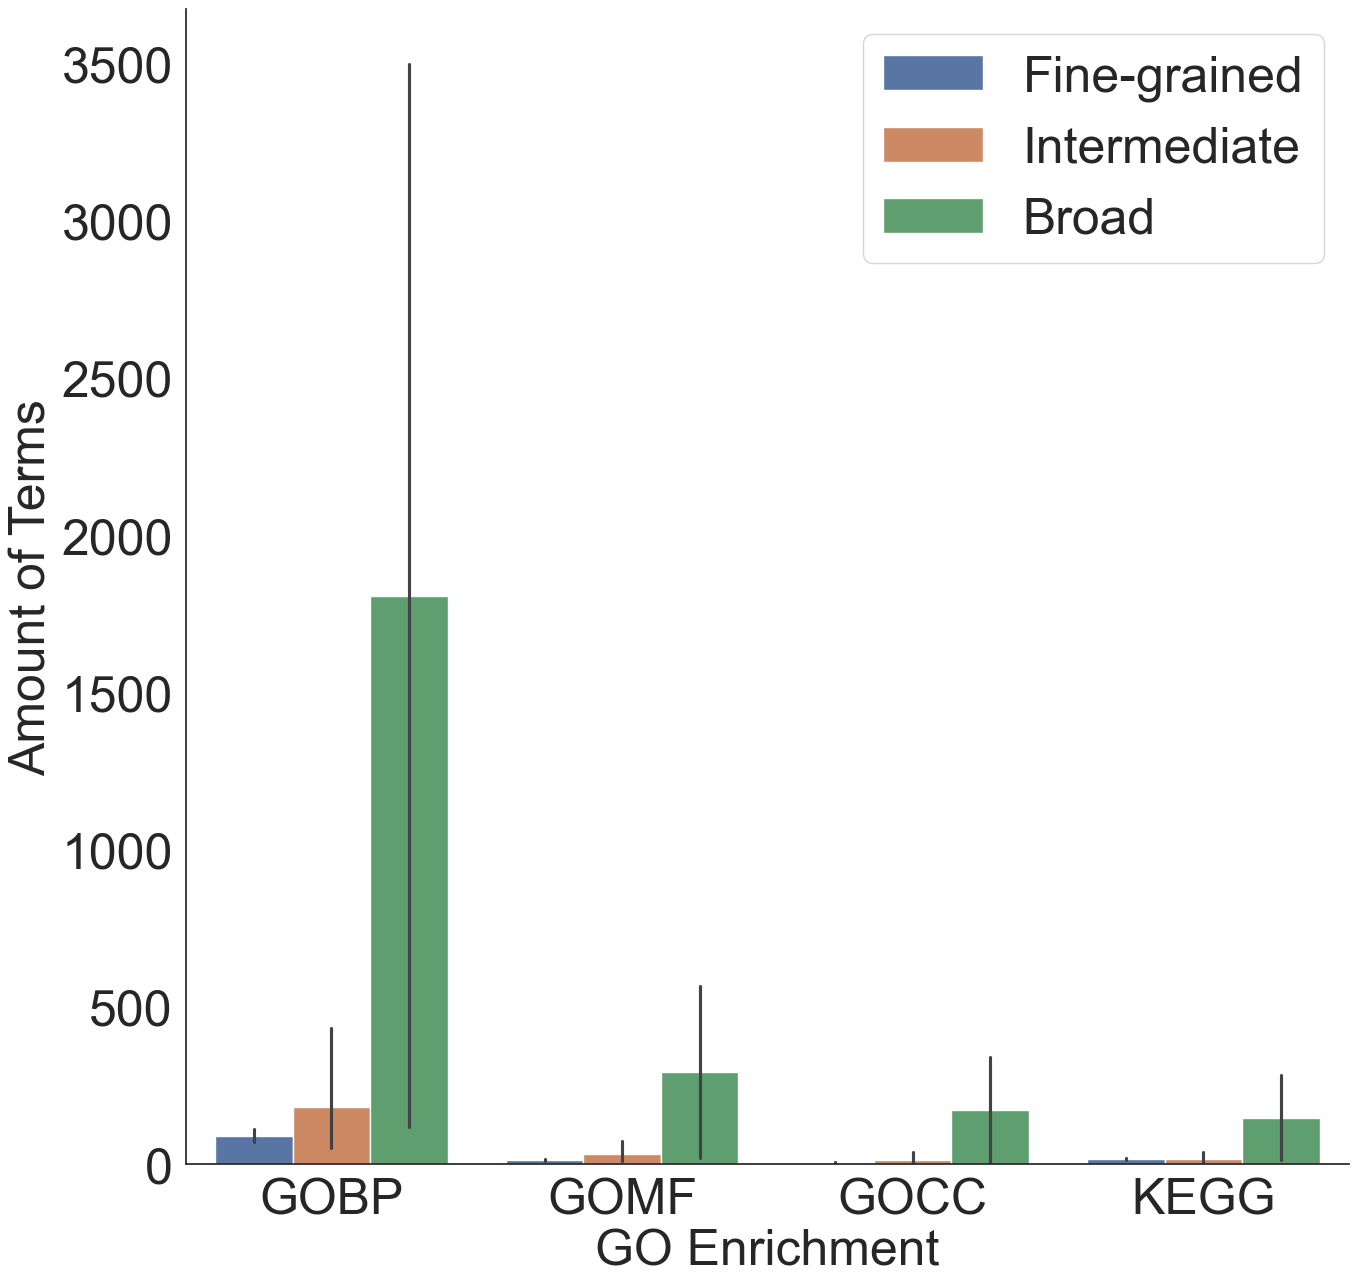

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

go_com_df=pd.DataFrame()

status_list=[]
num_terms_list=[]
level_list=[]

for i in fine_grained_communities_gobp_len:
    status_list.append("GOBP")
    num_terms_list.append(i)
    level_list.append("Fine-grained")
    
for i in fine_grained_communities_gomf_len:
    status_list.append("GOMF")
    num_terms_list.append(i)
    level_list.append("Fine-grained")
    
for i in fine_grained_communities_gocc_len:
    status_list.append("GOCC")
    num_terms_list.append(i)
    level_list.append("Fine-grained")   
    
for i in fine_grained_communities_kegg_len:
    status_list.append("KEGG")
    num_terms_list.append(i)
    level_list.append("Fine-grained")   
    
for i in middle_communities_gobp_len:
    status_list.append("GOBP")
    num_terms_list.append(i)
    level_list.append("Intermediate")
    
for i in middle_communities_gomf_len:
    status_list.append("GOMF")
    num_terms_list.append(i)
    level_list.append("Intermediate")
    
for i in middle_communities_gocc_len:
    status_list.append("GOCC")
    num_terms_list.append(i)
    level_list.append("Intermediate")   
    
for i in middle_communities_kegg_len:
    status_list.append("KEGG")
    num_terms_list.append(i)
    level_list.append("Intermediate")   
    
for i in broad_communities_gobp_len:
    status_list.append("GOBP")
    num_terms_list.append(i)
    level_list.append("Broad")
    
for i in broad_communities_gomf_len:
    status_list.append("GOMF")
    num_terms_list.append(i)
    level_list.append("Broad")
    
for i in broad_communities_gocc_len:
    status_list.append("GOCC")
    num_terms_list.append(i)
    level_list.append("Broad")  
    
for i in broad_communities_kegg_len:
    status_list.append("KEGG")
    num_terms_list.append(i)
    level_list.append("Broad")  
    
go_com_df['Status']=status_list
go_com_df['Enriched Terms']=num_terms_list
go_com_df['Hierarchy']=level_list


# Create a boxplot using seaborn
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x='Status', y='Enriched Terms', hue='Hierarchy', data=go_com_df)
#g.set_yscale("log")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)
plt.xticks(fontsize=36)

plt.xlabel('GO Enrichment', fontsize=36)
plt.ylabel('Amount of Terms', fontsize=36)
plt.legend(fontsize=36)
plt.savefig('output/Figures/SF17B_v00.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()



In [81]:
#Here, we will define a funnction that calculates the lcc for each set of terms in the GO tree to check for the 
#cohesiveness of the enrichment terms in each community
def lcc_significance(term_list,network):
    import random as rd
    import numpy as np
    z='nan'
    if len(set(term_list))>1:
        try:
            G_sub = nx.subgraph(network,term_list)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            f_lcc_size = G_sub_lcc.number_of_nodes()
        except:
            f_lcc_size = 1
            
        l_random_lccs = []

        S = 1000
        for s in range(S):
            term_sample = rd.sample(network.nodes(),len(set(term_list)))
            G_sub_rnd = nx.subgraph(network,term_sample)
            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = (f_lcc_size-mu)/std
    
    return z


#Here, we define a function that allows us to identify enrichment terms in the GO tree
def find_enclosed(s): 
    import re
    # find all matches
    matches = re.findall(r"\((.*?)\)", s) 
    matches = [x for x in matches if str(x).startswith("GO:")]
    # if there are no matches return None
    if len(matches) == 0:
        return None
    # if it is a valid number change its type to a number
    for i in range(len(matches)):
        try:
            matches[i] = int(matches[i])
        except:
            pass
    # if there is only one match return it without a list
    if len(matches) ==  1:
        return matches[0]
    return matches


def terms_extraction(enriched_terms):
    id_list1=[]
    for el in enriched_terms:
        id_list1.append(find_enclosed(el))
    return id_list1

In [82]:
#Let's import the latest release of the GO ontology
import obonet

url = 'http://purl.obolibrary.org/obo/go.obo'
graph = obonet.read_obo(url)
graph_up = nx.DiGraph.reverse(graph)

In [83]:
#Let's divide in the three branches
#BP
GOBP = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0008150')))
GOBP_undirected=GOBP.to_undirected()
#MF
GOMF = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0003674')))
GOMF_undirected=GOMF.to_undirected()
#CC
GOCC = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0005575')))
GOCC_undirected=GOCC.to_undirected()



fine_grained_communities_gobp_lcc_zscore={}
for com,term_list in fine_grained_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gobp_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOBP_undirected)

fine_grained_communities_gomf_lcc_zscore={}
for com,term_list in fine_grained_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gomf_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOMF_undirected)

fine_grained_communities_gocc_lcc_zscore={}
for com,term_list in fine_grained_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gocc_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOCC_undirected)


middle_communities_gobp_lcc_zscore={}
for com,term_list in middle_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gobp_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOBP_undirected)

middle_communities_gomf_lcc_zscore={}
for com,term_list in middle_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gomf_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOMF_undirected)

middle_communities_gocc_lcc_zscore={}
for com,term_list in middle_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gocc_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOCC_undirected)

    
broad_communities_gobp_lcc_zscore={}
for com,term_list in broad_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gobp_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOBP_undirected)

broad_communities_gomf_lcc_zscore={}
for com,term_list in broad_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gomf_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOMF_undirected)

broad_communities_gocc_lcc_zscore={}
for com,term_list in broad_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gocc_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOCC_undirected)


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/2782818402.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  term_sample = rd.sample(network.nodes(),len(set(term_list)))
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/2782818402.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  z = (f_lcc_size-mu)/std
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/2782818402.py:27: RuntimeWarning: invalid value encountered in scalar divide
  z = (f_lcc_size-mu)/std


In [84]:
with open('output/Communities/Infomap/fine_grained_communities_gobp_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gobp_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/fine_grained_communities_gomf_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gomf_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/fine_grained_communities_gocc_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gocc_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/middle_communities_gobp_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(middle_communities_gobp_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/middle_communities_gomf_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(middle_communities_gomf_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/middle_communities_gocc_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(middle_communities_gocc_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/broad_communities_gobp_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(broad_communities_gobp_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/broad_communities_gomf_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(broad_communities_gomf_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/broad_communities_gocc_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(broad_communities_gocc_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)
    

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/4177858724.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/4177858724.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


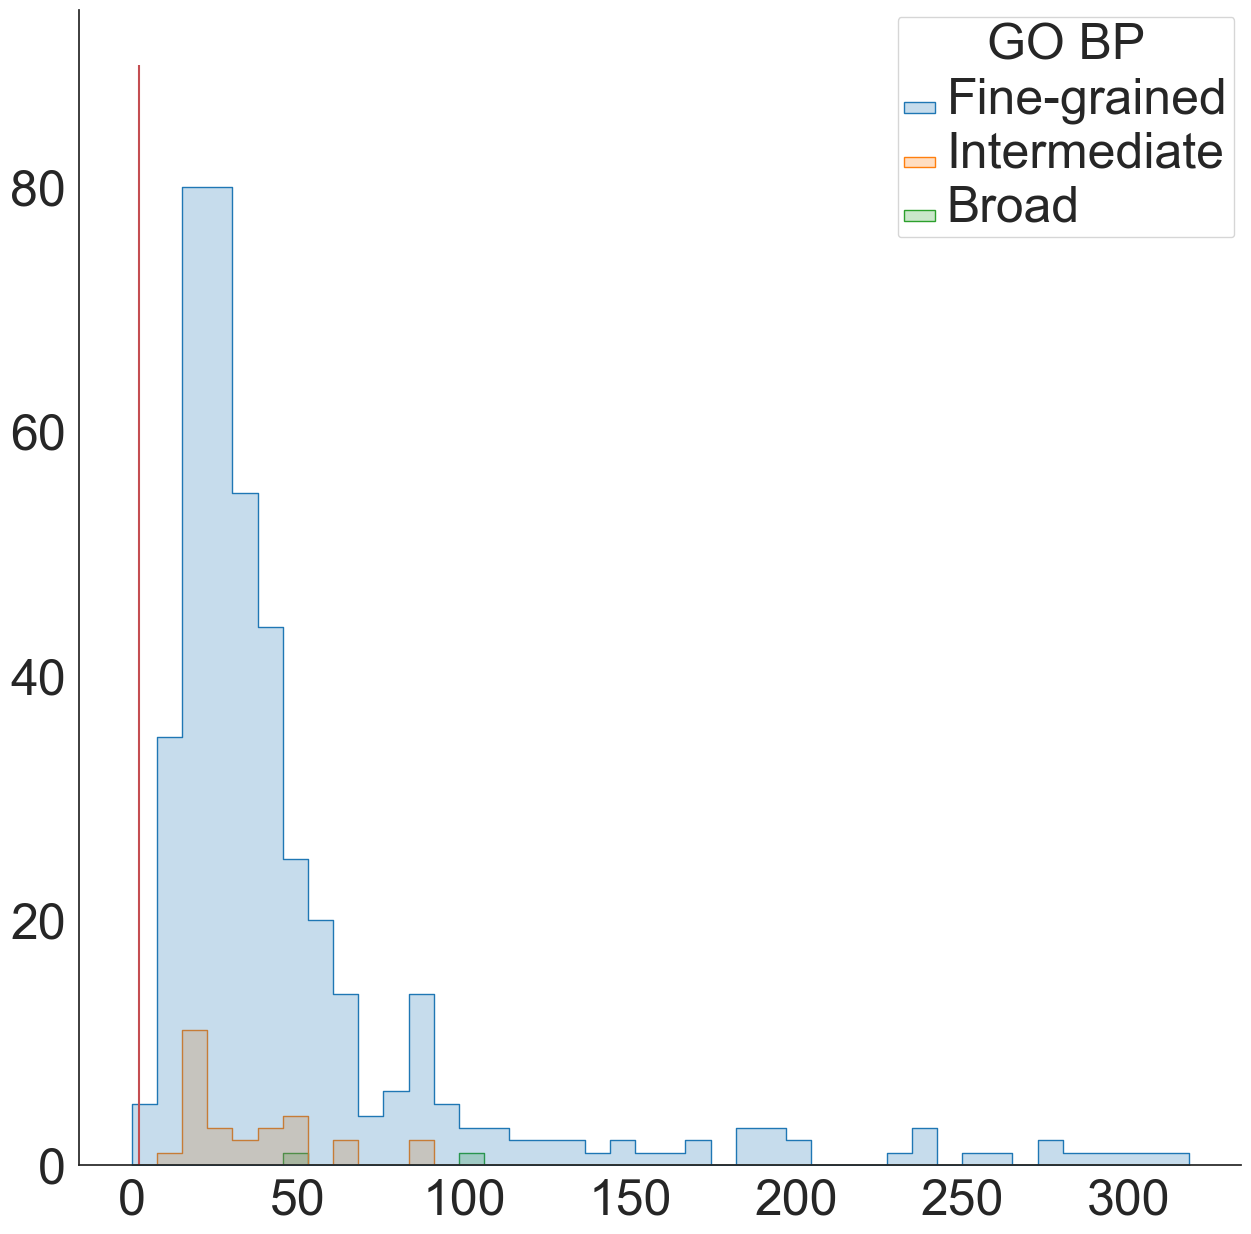

In [85]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_BP_lcc_zscore=[]
iteration=[]
for com, zscore in fine_grained_communities_gobp_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_BP_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_BP_lcc_zscore=[]

for com, zscore in middle_communities_gobp_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_BP_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_BP_lcc_zscore=[]

for com, zscore in broad_communities_gobp_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_BP_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_BP_lcc_zscore+middle_BP_lcc_zscore+broad_BP_lcc_zscore
goterms_lcc_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=90,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO BP", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF17C_1_v02.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/709102915.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/709102915.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


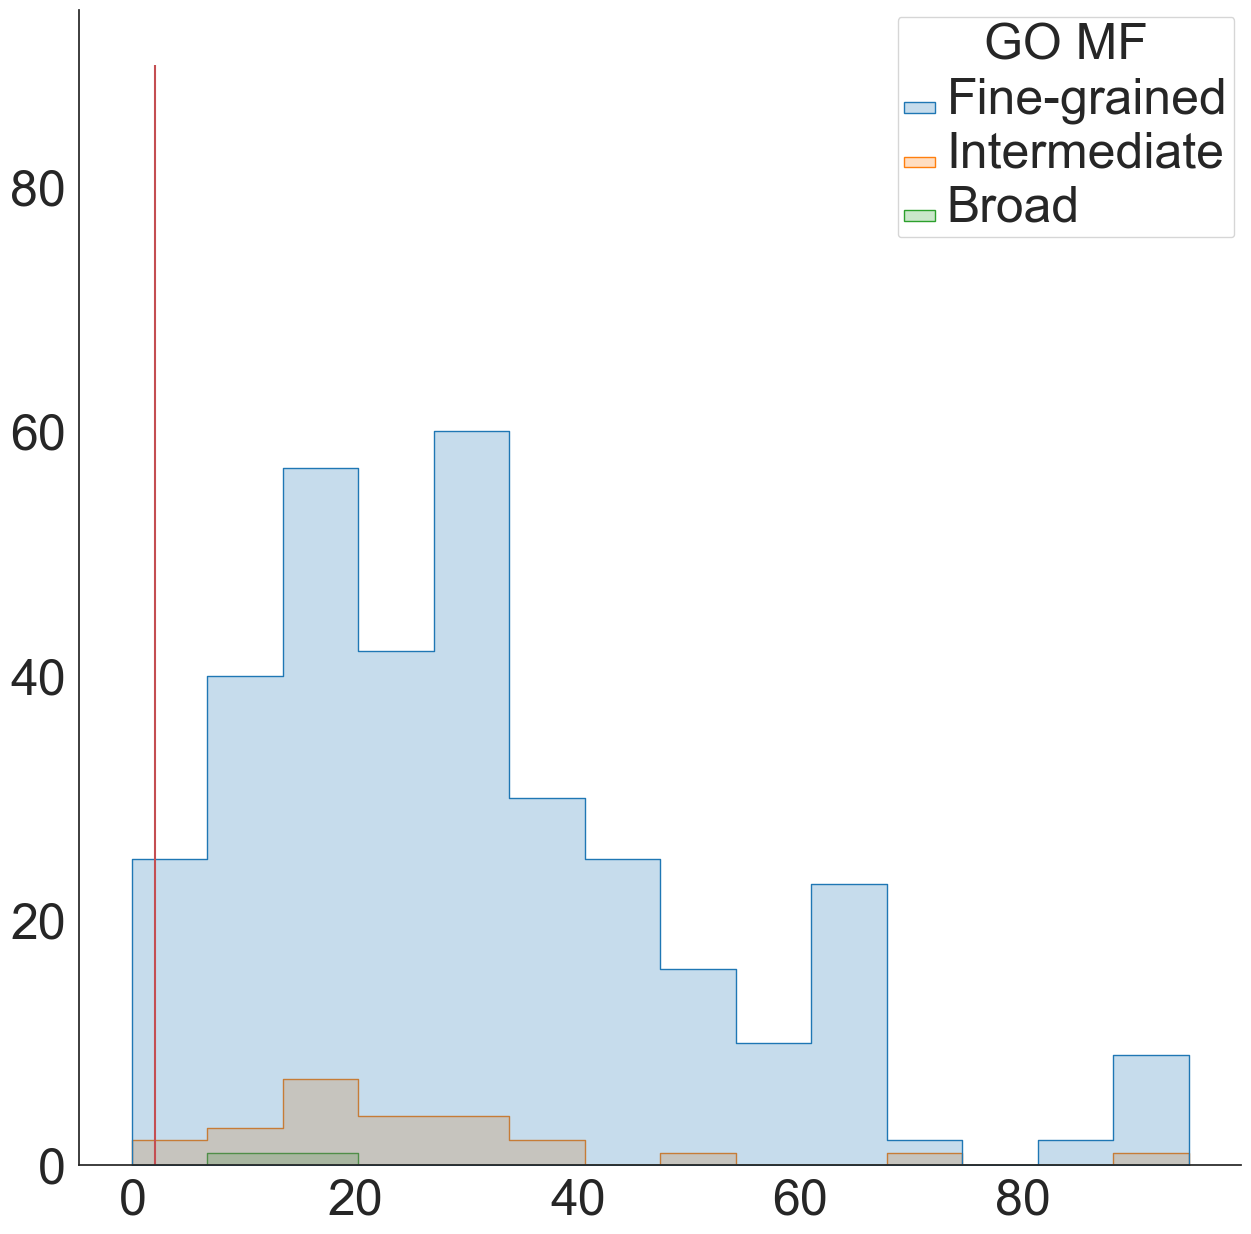

In [86]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_MF_lcc_zscore=[]
iteration=[]
for com, zscore in fine_grained_communities_gomf_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_MF_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_MF_lcc_zscore=[]

for com, zscore in middle_communities_gomf_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_MF_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_MF_lcc_zscore=[]

for com, zscore in broad_communities_gomf_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_MF_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_MF_lcc_zscore+middle_MF_lcc_zscore+broad_MF_lcc_zscore
goterms_lcc_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=90,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO MF", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF17C_2_v02.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/2104923929.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/2104923929.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


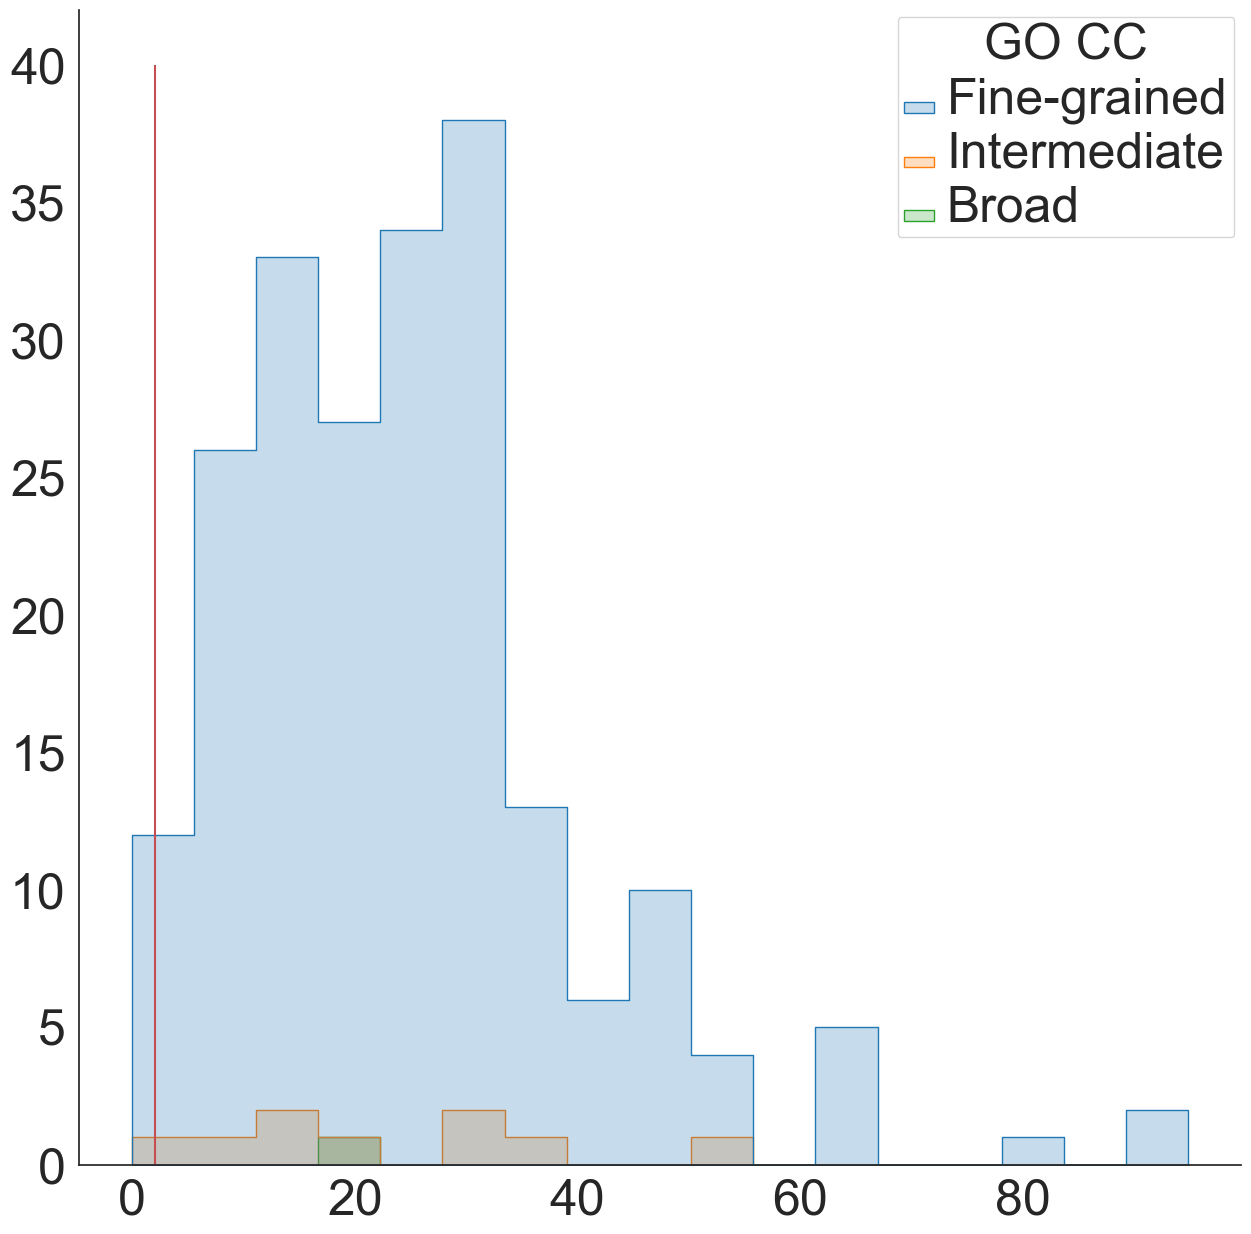

In [87]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_CC_lcc_zscore=[]
iteration=[]
for com, zscore in fine_grained_communities_gocc_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_CC_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_CC_lcc_zscore=[]

for com, zscore in middle_communities_gocc_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_CC_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_CC_lcc_zscore=[]

for com, zscore in broad_communities_gocc_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_CC_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_CC_lcc_zscore+middle_CC_lcc_zscore+broad_CC_lcc_zscore
goterms_lcc_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=40,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO CC", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF17C_3_v02.pdf',format='pdf',dpi=300, bbox_inches = "tight")

In [88]:
finegrained_enriched_terms=finegrained_BP_lcc_zscore+finegrained_MF_lcc_zscore+finegrained_CC_lcc_zscore
middle_enriched_terms=middle_BP_lcc_zscore+middle_MF_lcc_zscore+middle_CC_lcc_zscore
broad_enriched_terms=broad_BP_lcc_zscore+broad_MF_lcc_zscore+broad_CC_lcc_zscore

In [92]:
from scipy import stats

In [97]:
t_value,p_value=stats.ttest_ind(finegrained_enriched_terms,middle_enriched_terms)
print("The p-value between fine-grained and middle communities GO z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms,middle_enriched_terms)
print("The p-value between broad and middle communities of GO z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms,finegrained_enriched_terms)
print("The p-value between broad and fine-grained communities of GO z-score distributions is %s" %p_value)

The p-value between fine-grained and middle communities GO z-score distributions is 0.12229212600067223
The p-value between broad and middle communities of GO z-score distributions is 0.3500050954069903
The p-value between broad and fine-grained communities of GO z-score distributions is 0.9116649946339292


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/343037455.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["z-score lcc"],estimator=np.median, palette="Blues_d",linewidth=5)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/343037455.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/343037455.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


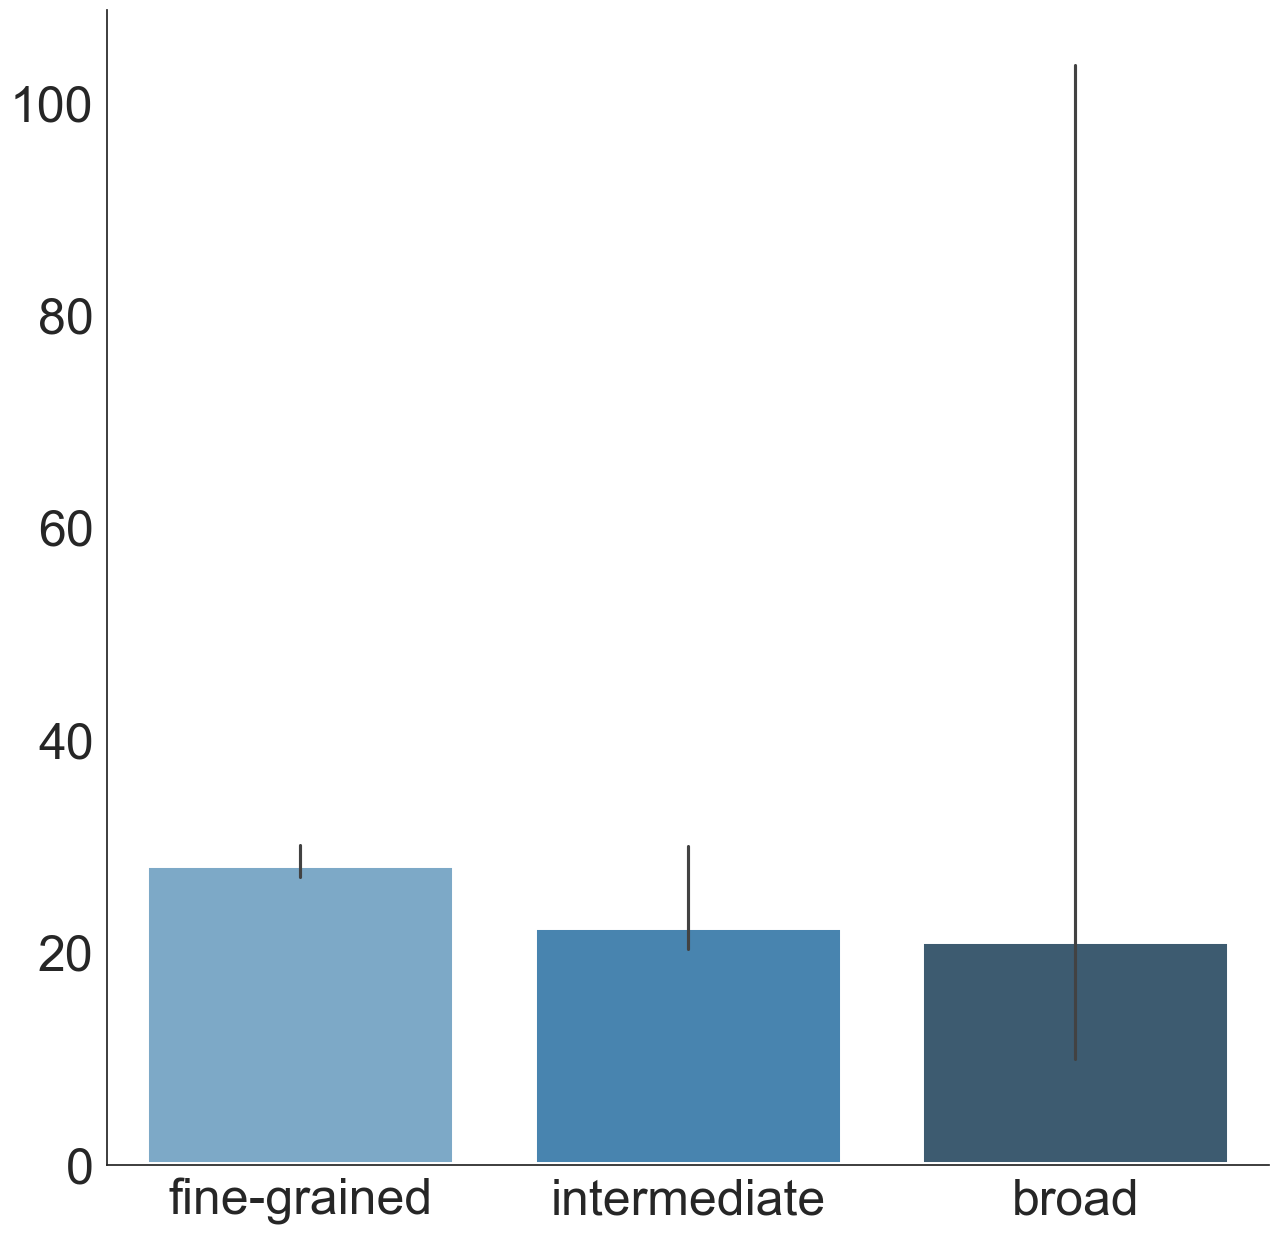

In [90]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community


column_names = ["z-score lcc", "louvain Iteration"]
labels=['fine-grained','intermediate','broad']
zscore_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("broad")
    
EEN_louvain_com_df = pd.DataFrame(columns = column_names)
EEN_louvain_com_df["z-score lcc"]=zscore_list_tot
EEN_louvain_com_df["Louvain Iteration"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["z-score lcc"],estimator=np.median, palette="Blues_d",linewidth=5)

#ax = sns.barplot(x="louvain Iteration", y="z-score lcc", data=EEN_louvain_com_df,
#                 palette="Blues_d")
#g.set_yscale("log")
#ax.set_xlabel("Louvain iteration",fontsize=32)
#ax.set_ylabel("lcc z-score enriched terms",fontsize=32)
ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
plt.savefig('output/Figures/SF17D_v00.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [96]:
from scipy import stats

t_value,p_value=stats.ttest_ind(finegrained_MF_lcc_zscore,middle_MF_lcc_zscore)
print("The p-value between fine-grained and middle communities of MF z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_MF_lcc_zscore,middle_MF_lcc_zscore)
print("The p-value between broad and middle communities of MF z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_MF_lcc_zscore,finegrained_MF_lcc_zscore)
print("The p-value between broad and fine-grained communities of MF z-score distributions is %s" %p_value)


t_value,p_value=stats.ttest_ind(finegrained_BP_lcc_zscore,middle_BP_lcc_zscore)
print("The p-value between fine-grained and middle communities of BP z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_BP_lcc_zscore,middle_BP_lcc_zscore)
print("The p-value between broad and middle communities of BP z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_BP_lcc_zscore,finegrained_BP_lcc_zscore)
print("The p-value between broad and fine-grained communities of BP z-score distributions is %s" %p_value)

t_value,p_value=stats.ttest_ind(finegrained_CC_lcc_zscore,middle_CC_lcc_zscore)
print("The p-value between fine-grained and middle communities of CC z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_CC_lcc_zscore,middle_CC_lcc_zscore)
print("The p-value between broad and middle communities of CC z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_CC_lcc_zscore,finegrained_CC_lcc_zscore)
print("The p-value between broad and fine-grained communities of CC z-score distributions is %s" %p_value)



The p-value between fine-grained and middle communities of MF z-score distributions is 0.2856578144399426
The p-value between broad and middle communities of MF z-score distributions is 0.3577708987317021
The p-value between broad and fine-grained communities of MF z-score distributions is 0.19974777355365833
The p-value between fine-grained and middle communities of BP z-score distributions is 0.15045260211262682
The p-value between broad and middle communities of BP z-score distributions is 0.01648357202243515
The p-value between broad and fine-grained communities of BP z-score distributions is 0.4788803976098617
The p-value between fine-grained and middle communities of CC z-score distributions is 0.8853986536379679
The p-value between broad and middle communities of CC z-score distributions is 0.8820696699107953
The p-value between broad and fine-grained communities of CC z-score distributions is 0.827970632753289


In [122]:

#Let's import the results
with open('output/Communities/Infomap/fine_grained_communities_gobp_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/fine_grained_communities_gomf_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/fine_grained_communities_gocc_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Infomap/middle_communities_gobp_resnik.pickle', 'rb') as handle:
    middle_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/middle_communities_gomf_resnik.pickle', 'rb') as handle:
    middle_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/middle_communities_gocc_resnik.pickle', 'rb') as handle:
    middle_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Infomap/broad_communities_gobp_resnik.pickle', 'rb') as handle:
    broad_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/broad_communities_gomf_resnik.pickle', 'rb') as handle:
    broad_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/broad_communities_gocc_resnik.pickle', 'rb') as handle:
    broad_communities_gocc_resnik = pk.load(handle)
    
#Let's import the random expectations
with open('output/Communities/Infomap/rd_fine_grained_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/rd_middle_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Infomap/rd_broad_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gomf_resnik = pk.load(handle)
with open('output/Communities/Infomap/rd_fine_grained_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gocc_resnik = pk.load(handle)    
with open('output/Communities/Infomap/rd_middle_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gocc_resnik = pk.load(handle)    
with open('output/Communities/Infomap/rd_broad_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Infomap/rd_fine_grained_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/rd_middle_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Infomap/rd_broad_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gobp_resnik = pk.load(handle)
    

/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/3310038106.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/3310038106.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


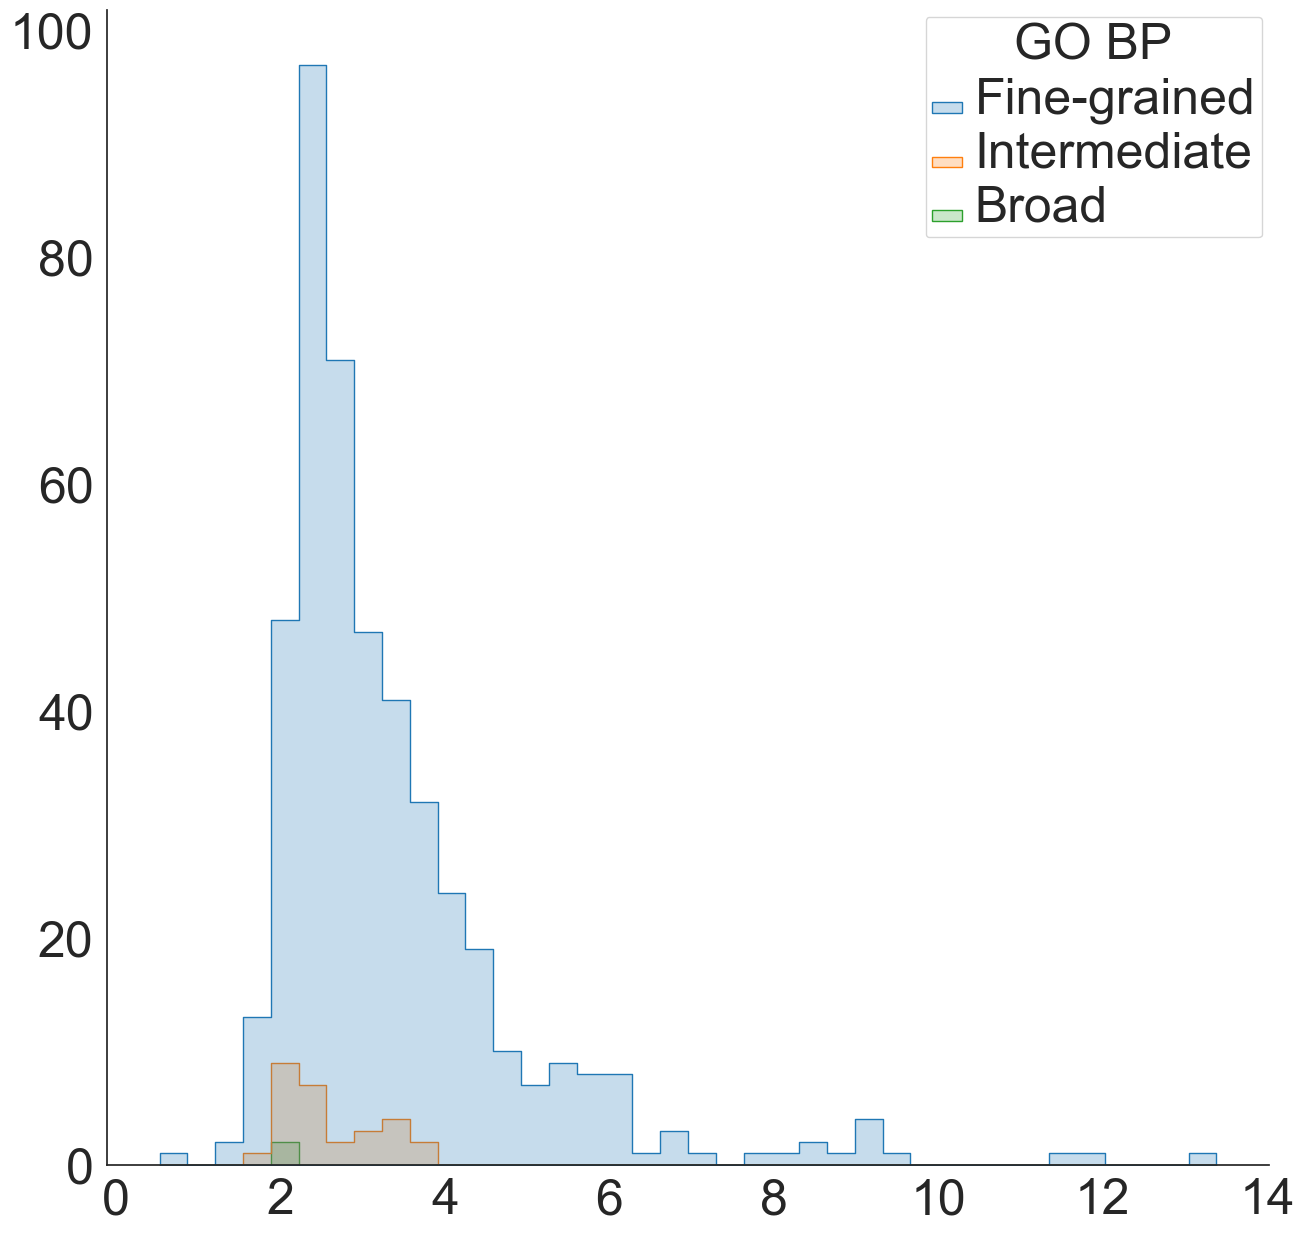

In [123]:
goterms_resnik_df=pd.DataFrame()

finegrained_BP_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_BP_resnik=[]
for com, resnik in middle_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_BP_resnik=[]
for com, resnik in broad_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_BP_resnik+middle_BP_resnik+broad_BP_resnik
goterms_resnik_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO BP", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF18B_1_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/121171304.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/121171304.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


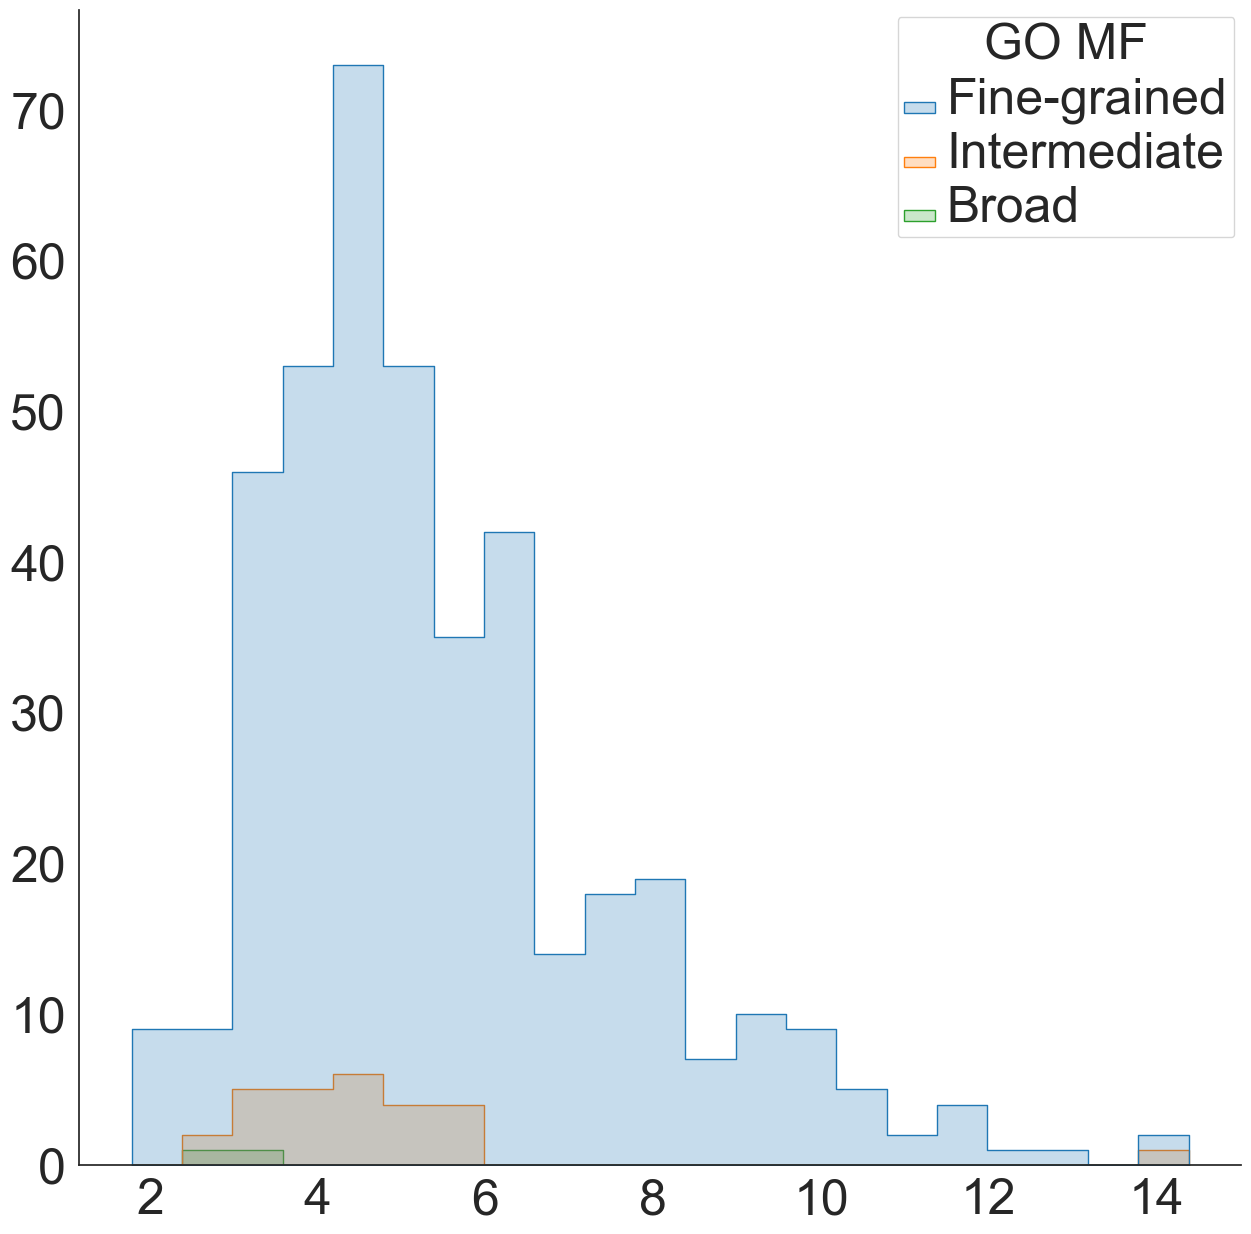

In [124]:
goterms_resnik_df=pd.DataFrame()

finegrained_MF_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_MF_resnik=[]
for com, resnik in middle_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_MF_resnik=[]
for com, resnik in broad_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_MF_resnik+middle_MF_resnik+broad_MF_resnik
goterms_resnik_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO MF", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF18B_2_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/1975119871.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/1975119871.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


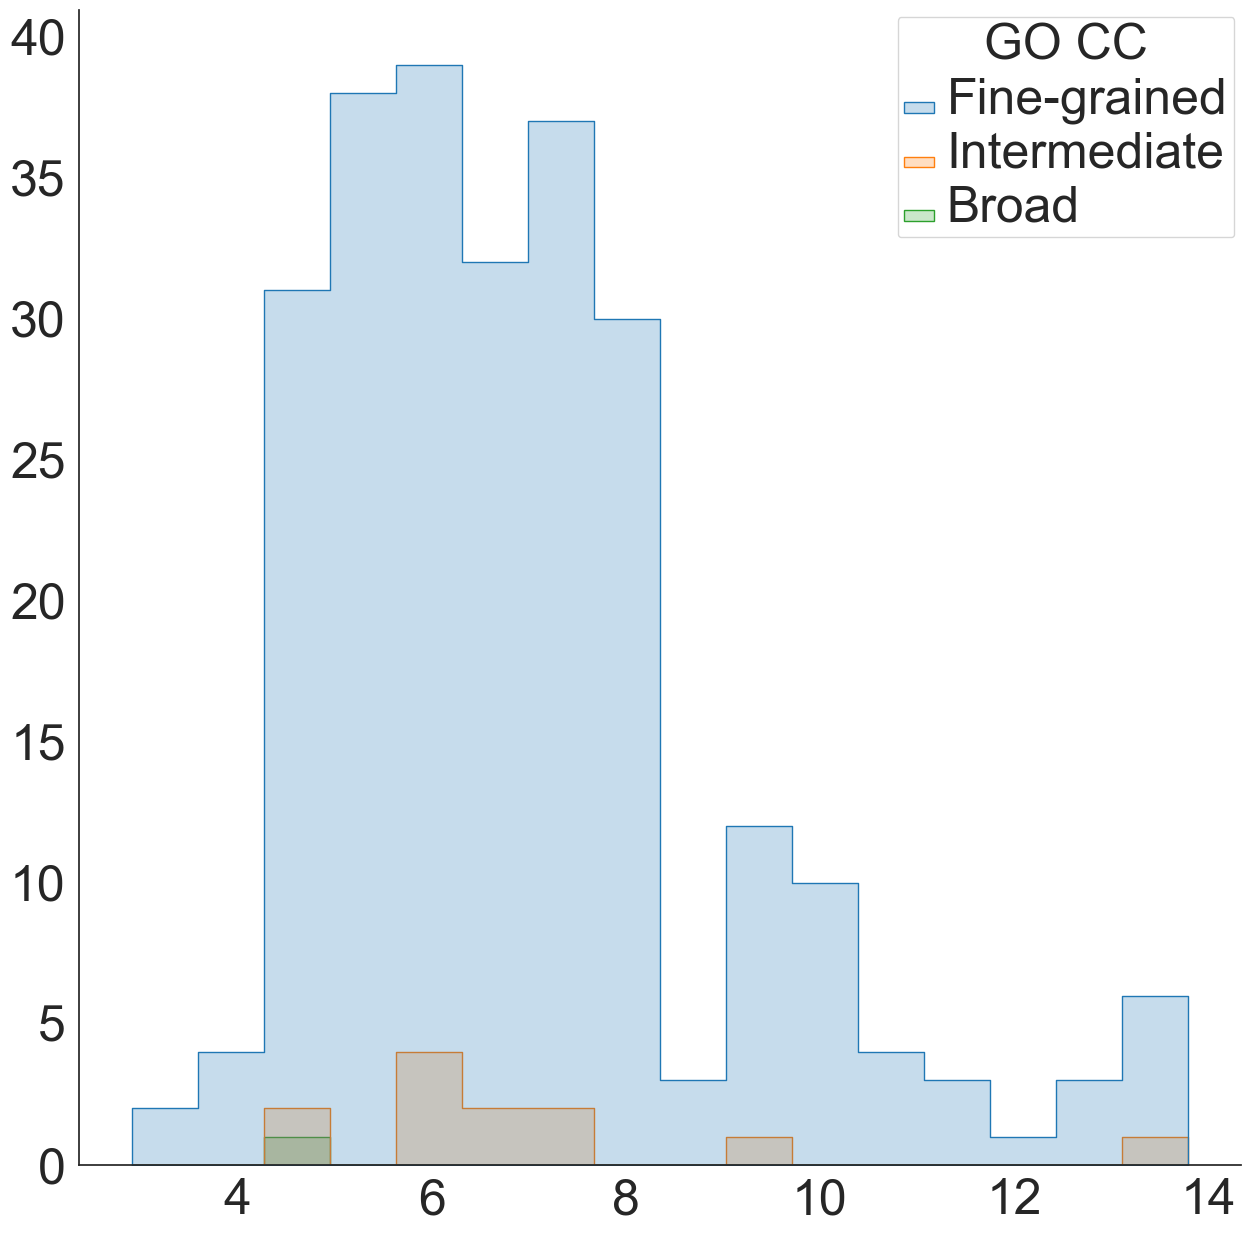

In [125]:
goterms_resnik_df=pd.DataFrame()

finegrained_CC_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_CC_resnik=[]
for com, resnik in middle_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_CC_resnik=[]
for com, resnik in broad_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_CC_resnik+middle_CC_resnik+broad_CC_resnik
goterms_resnik_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO CC", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF18B_3_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [126]:
finegrained_enriched_terms_resnik = finegrained_BP_resnik+finegrained_MF_resnik+finegrained_CC_resnik
middle_enriched_terms_resnik = middle_BP_resnik+middle_MF_resnik+middle_CC_resnik
broad_enriched_terms_resnik = broad_BP_resnik+broad_MF_resnik+broad_CC_resnik

finegrained_enriched_terms_resnik_clean = [i for i in finegrained_enriched_terms_resnik if str(i)!='nan']
middle_enriched_terms_resnik_clean = [i for i in middle_enriched_terms_resnik if str(i)!='nan']
broad_enriched_terms_resnik_clean = [i for i in broad_enriched_terms_resnik if str(i)!='nan']

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/431733736.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/431733736.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


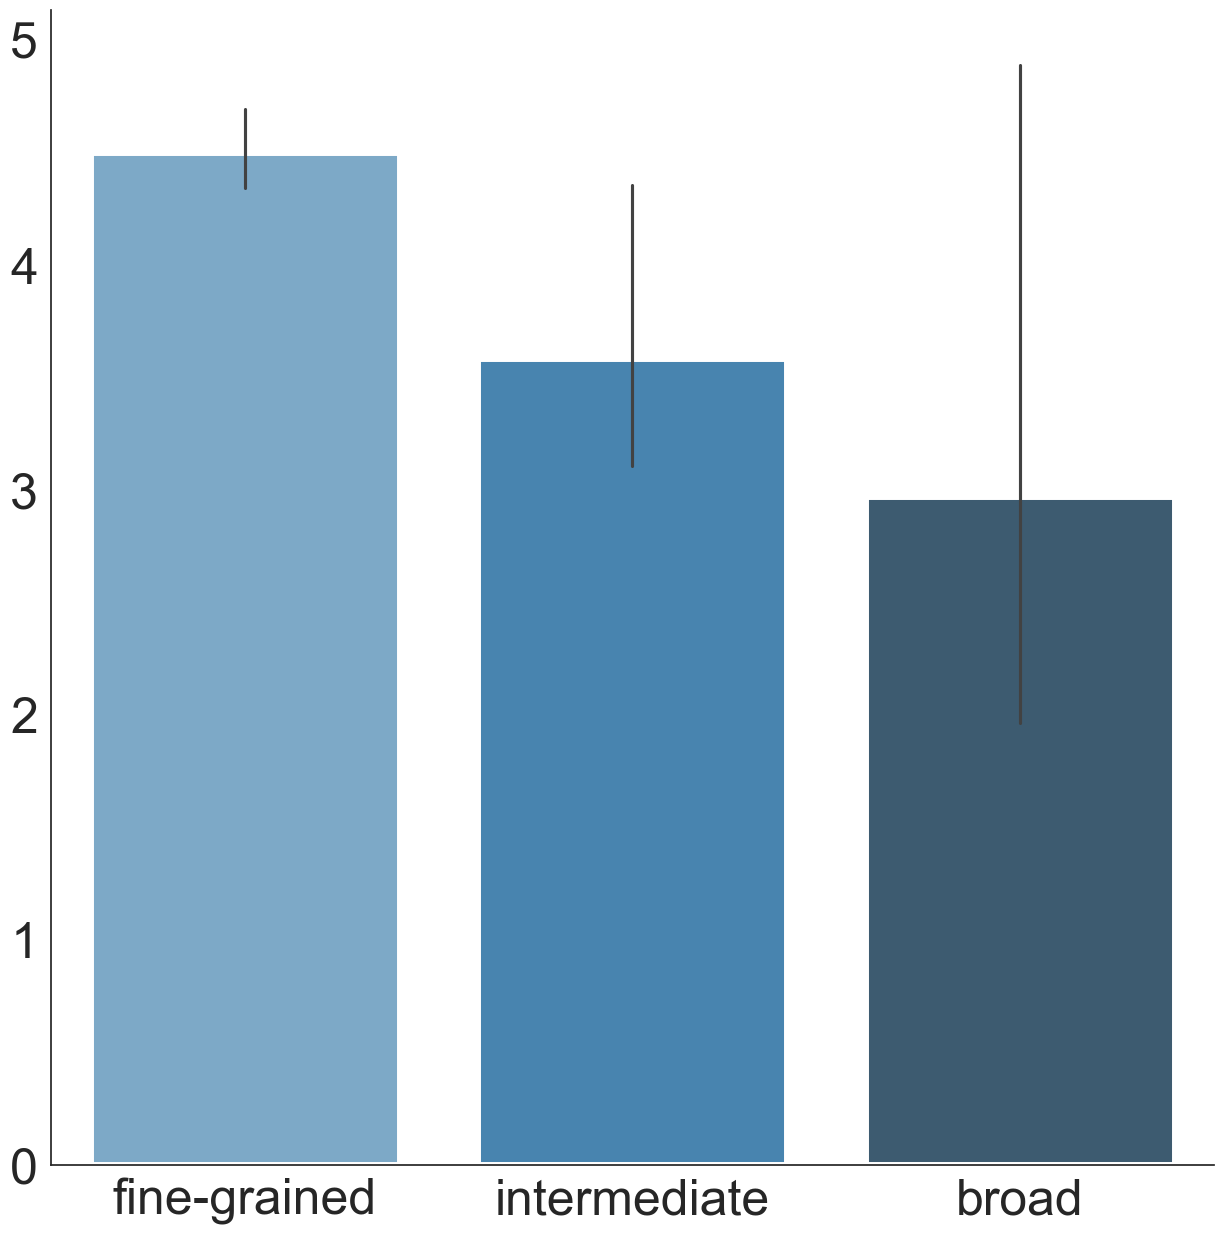

In [127]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community

column_names = ["resnik", "louvain Iteration"]
labels=['fine-grained','intermediate','broad']
resnik_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("broad")
    
EEN_louvain_com_df = pd.DataFrame(columns = column_names)
EEN_louvain_com_df["resnik"]=resnik_list_tot
EEN_louvain_com_df["Louvain Iteration"]=group_list


fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["resnik"],estimator=np.median, hue=EEN_louvain_com_df["Louvain Iteration"], palette="Blues_d",legend=False,linewidth=5)


ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
plt.savefig('output/Figures/SF18A_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [128]:
t_value,p_value=stats.ttest_ind(finegrained_enriched_terms_resnik_clean,middle_enriched_terms_resnik_clean)
print("The p-value between fine-grained and middle communities GO Resnik distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms_resnik_clean,middle_enriched_terms_resnik_clean)
print("The p-value between broad and middle communities of GO Resnik distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms_resnik_clean,finegrained_enriched_terms_resnik_clean)
print("The p-value between broad and fine-grained communities of GO Resnik distributions is %s" %p_value)

The p-value between fine-grained and middle communities GO Resnik distributions is 0.015473730135317025
The p-value between broad and middle communities of GO Resnik distributions is 0.25300810966584186
The p-value between broad and fine-grained communities of GO Resnik distributions is 0.06506223699439594


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/2538308956.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/2538308956.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


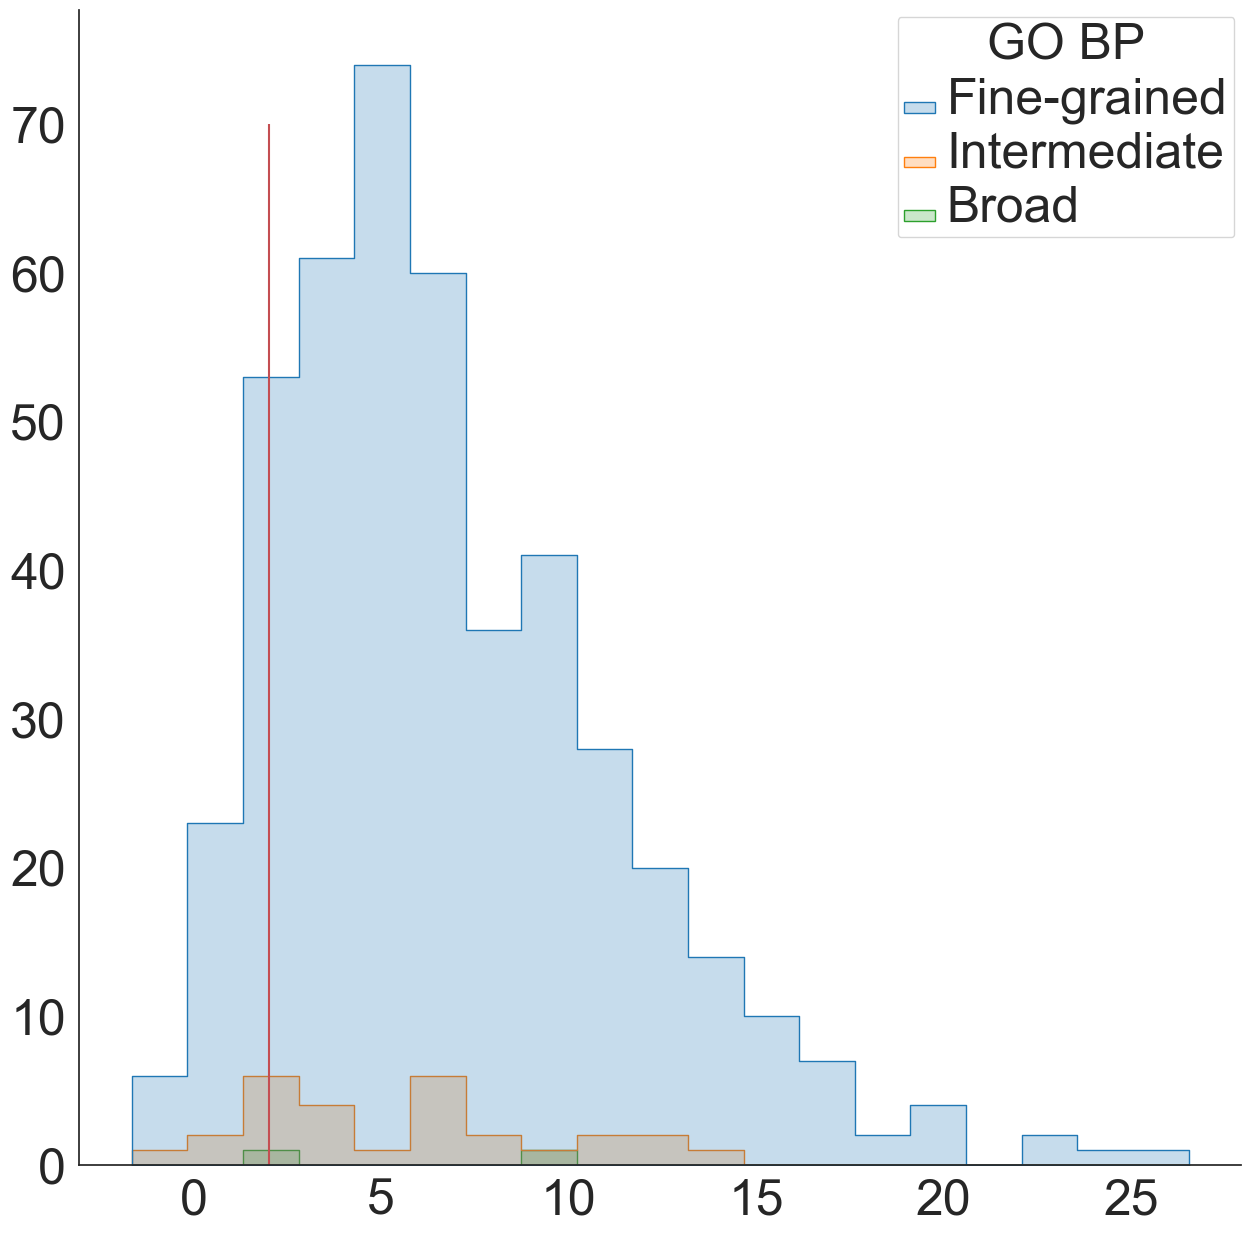

In [110]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_BP_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_BP_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_BP_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_BP_resnik_zscore+middle_BP_resnik_zscore+broad_BP_resnik_zscore
goterms_resnik_zscore_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=70,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO BP", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF18C_1_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/326337264.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/326337264.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


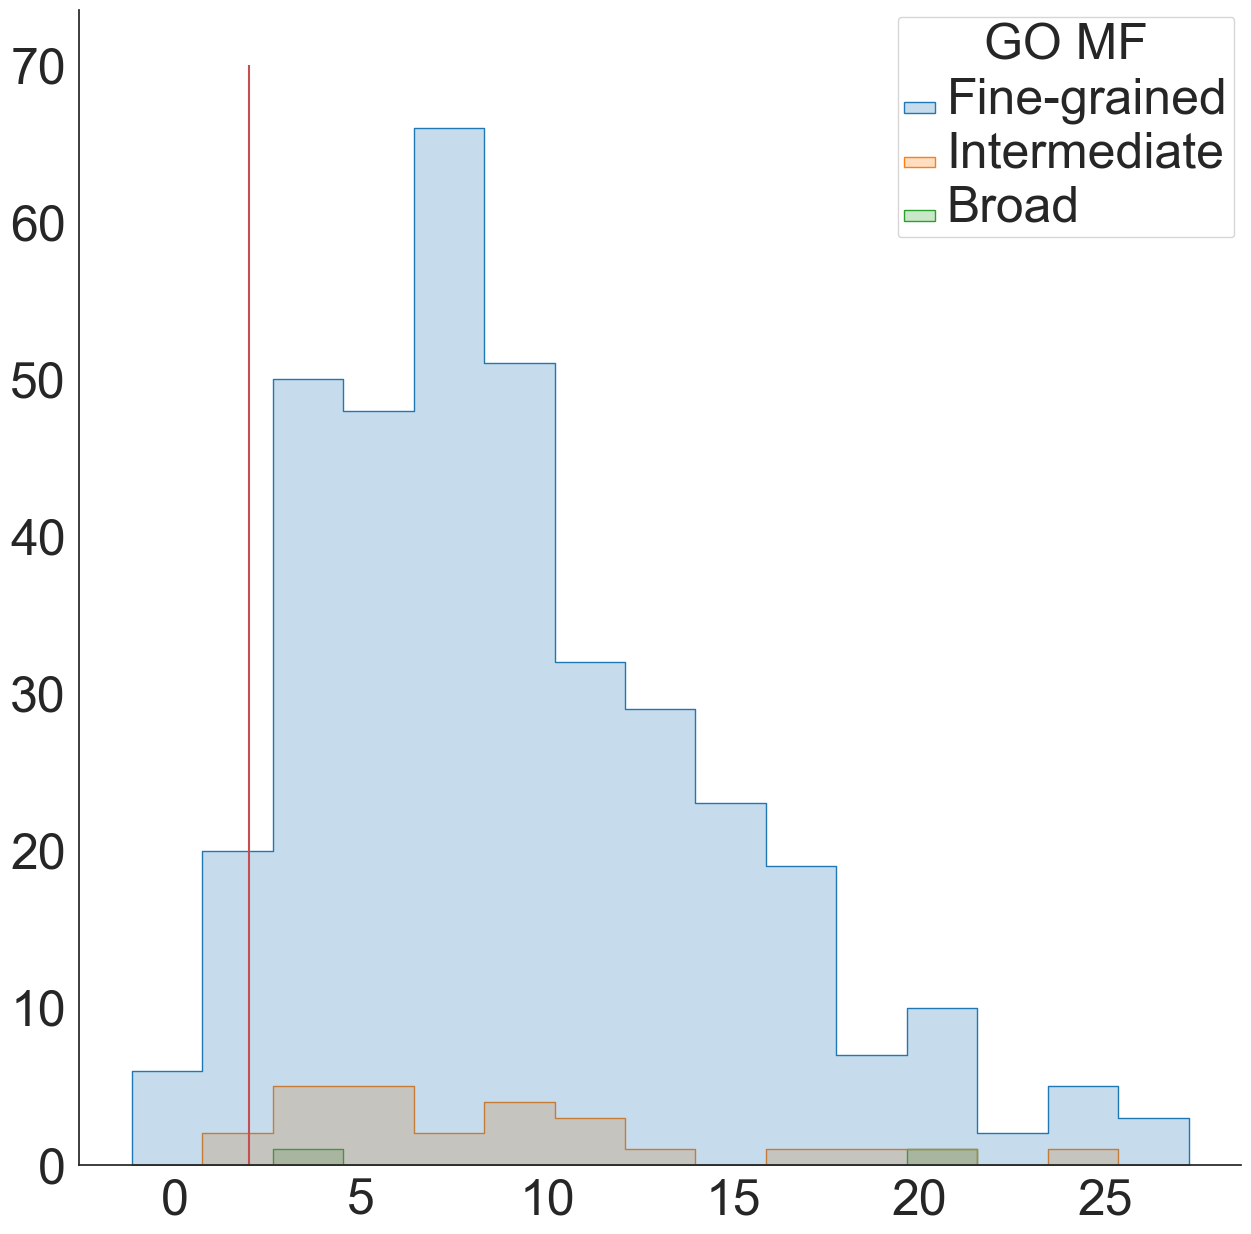

In [111]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_MF_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_MF_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_MF_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_MF_resnik_zscore+middle_MF_resnik_zscore+broad_MF_resnik_zscore
goterms_resnik_zscore_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=70,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO MF", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF18C_2_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/1856834718.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_4616/1856834718.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


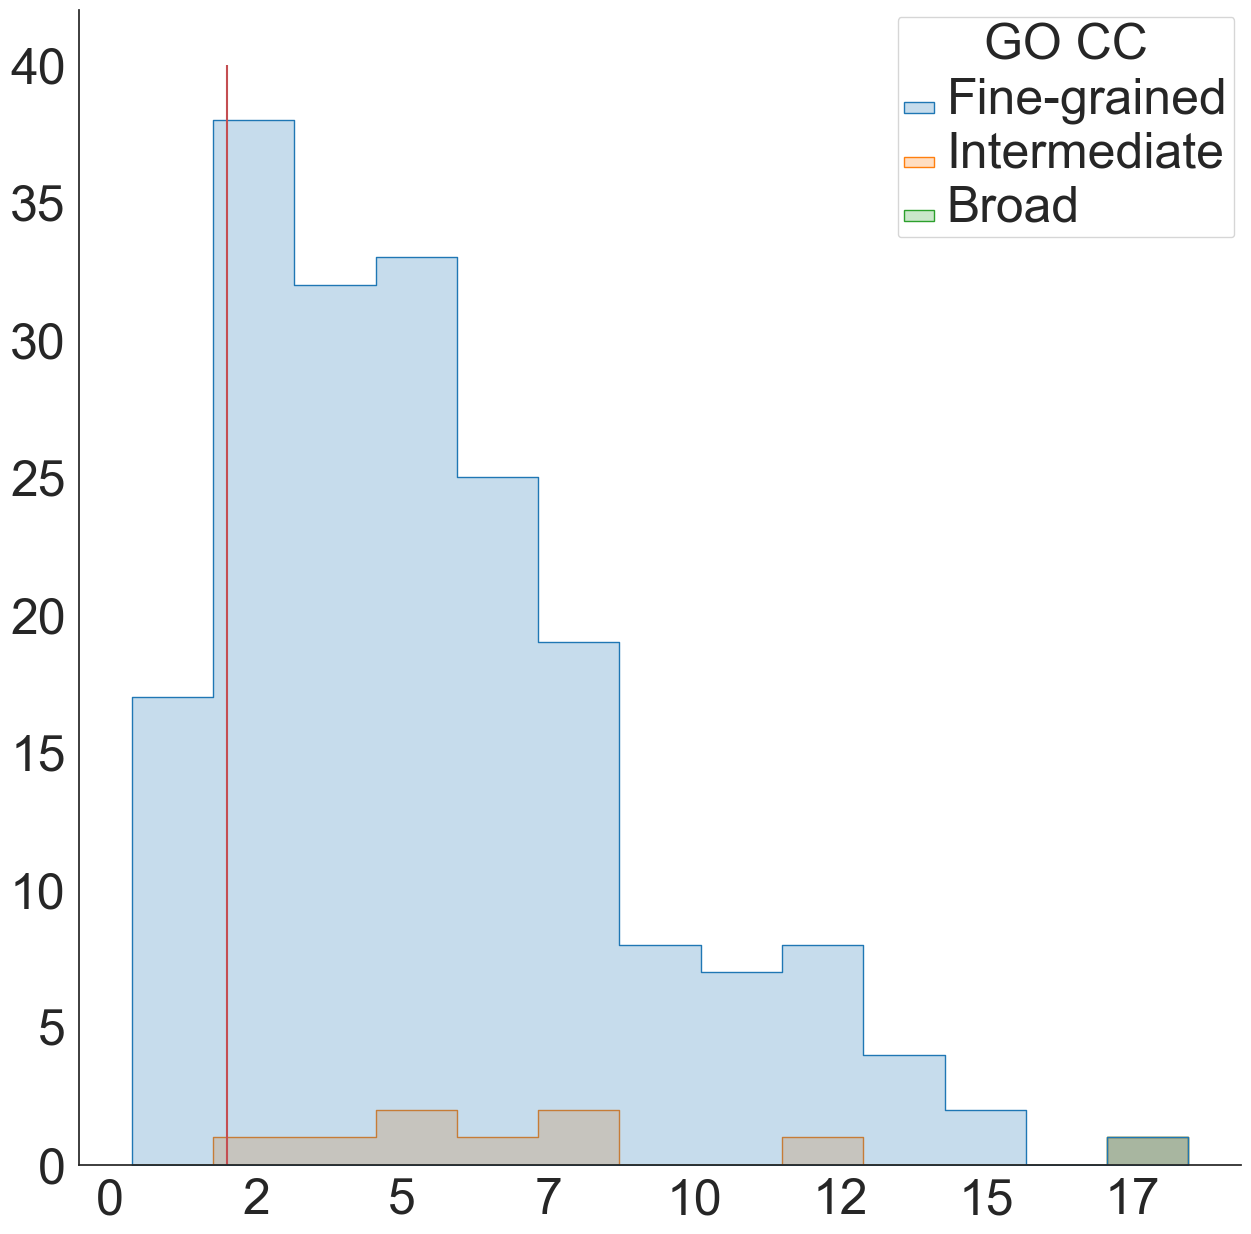

In [112]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_CC_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_CC_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_CC_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_CC_resnik_zscore+middle_CC_resnik_zscore+broad_CC_resnik_zscore
goterms_resnik_zscore_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=40,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO CC", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF18C_3_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [114]:
#Let's calculate the network density for each of the communities of the EEN

def calculate_density_LSD(network, group):
    # Create a subnetwork of the total network
    G_subgraph = network.subgraph(group)
    # Calculate the density of that subnetwork
    density = nx.density(G_subgraph)
    return density



infomap_fine_grained_density_com_dict={}
for com,explist in infomap_fine_grained_communities_dict.items():
    if len(explist)>2:                    #we exclude communities that have less(equal) than 2 chemicals
        infomap_fine_grained_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

infomap_middle_density_com_dict={}
for com,explist in infomap_middle_communities_dict.items():
    if len(explist)>2:                    #we exclude communities that have less(equal) than 2 chemicals      
        infomap_middle_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

infomap_broad_density_com_dict={}
for com,explist in infomap_broad_communities_dict.items():
    if len(explist)>2:                    #we exclude communities that have less(equal) than 2 chemicals
        infomap_broad_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

   
with open('output/Communities/Infomap/infomap_fine_grained_density_com_dict.pickle', 'wb') as handle:
    pk.dump(infomap_fine_grained_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/infomap_middle_density_com_dict.pickle', 'wb') as handle:
    pk.dump(infomap_middle_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/infomap_broad_density_com_dict.pickle', 'wb') as handle:
    pk.dump(infomap_broad_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

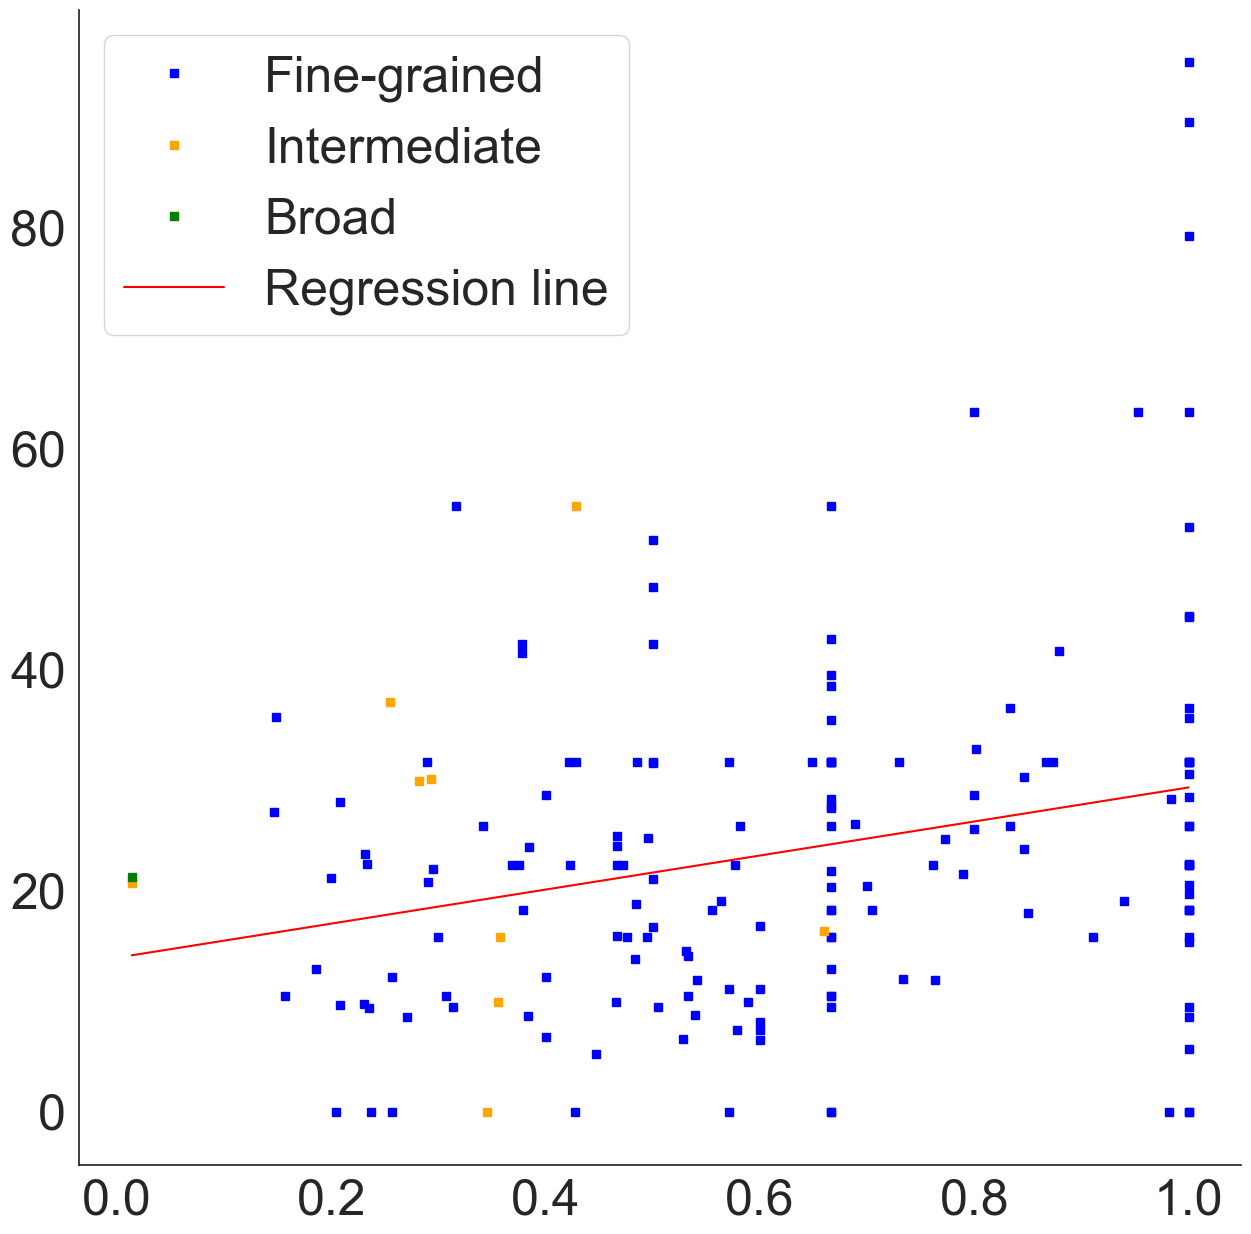

In [115]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats


tot_density_com_list=[]
tot_cclcc_list=[]
fine_grained_density_com_list=[]
fine_grained_cclcc_com_list=[]

for com,net_density in infomap_fine_grained_density_com_dict.items():
    lcczscore=fine_grained_communities_gocc_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        fine_grained_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_cclcc_list.append(lcczscore)
        fine_grained_cclcc_com_list.append(lcczscore)
 
middle_density_com_list=[]
middle_cclcc_com_list=[]
for com,net_density in infomap_middle_density_com_dict.items():
    lcczscore=middle_communities_gocc_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        middle_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_cclcc_list.append(lcczscore)
        middle_cclcc_com_list.append(lcczscore)
        
   
broad_density_com_list=[]
broad_cclcc_com_list=[]
for com,net_density in infomap_broad_density_com_dict.items():
    lcczscore=broad_communities_gocc_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        broad_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_cclcc_list.append(lcczscore)
        broad_cclcc_com_list.append(lcczscore)
        

    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(tot_density_com_list, tot_cclcc_list)

ax.plot(fine_grained_density_com_list,fine_grained_cclcc_com_list, linewidth=0, marker='s',c='blue', label='Fine-grained')
ax.plot(middle_density_com_list,middle_cclcc_com_list, linewidth=0, marker='s',c='orange', label='Intermediate')
ax.plot(broad_density_com_list,broad_cclcc_com_list, linewidth=0, marker='s',c='green', label='Broad')

y=[]
for i in tot_density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(tot_density_com_list, y,c='red', label=line)
#ax.set_xlabel('Network Density', fontsize=18)
#ax.set_ylabel('Z-score lcc',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Figures/SF19C.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [116]:
print(scipy.stats.pearsonr(tot_density_com_list, tot_cclcc_list))  # Pearson's r
print(scipy.stats.spearmanr(tot_density_com_list, tot_cclcc_list)) # Spearman's rho

PearsonRResult(statistic=0.25796538810568354, pvalue=0.0005890140465760823)
SignificanceResult(statistic=0.22412536585983064, pvalue=0.0029488201223365203)


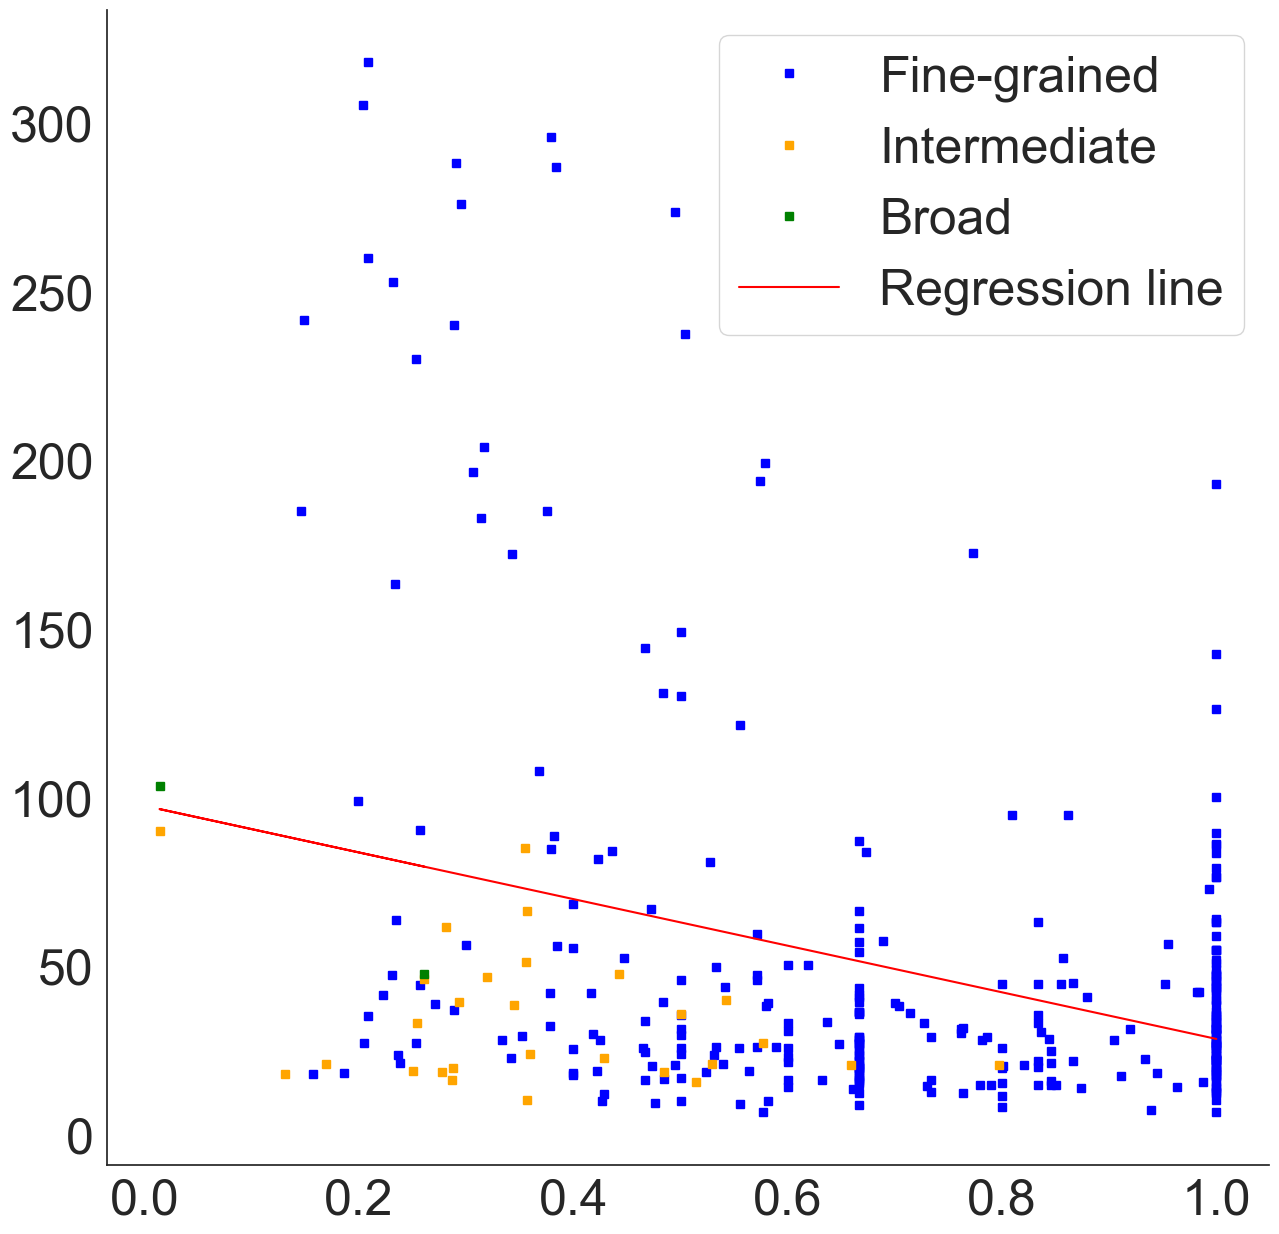

In [117]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats


tot_density_com_list=[]
tot_bplcc_list=[]
fine_grained_density_com_list=[]
fine_grained_bplcc_com_list=[]

for com,net_density in infomap_fine_grained_density_com_dict.items():
    lcczscore=fine_grained_communities_gobp_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        fine_grained_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_bplcc_list.append(lcczscore)
        fine_grained_bplcc_com_list.append(lcczscore)
 
middle_density_com_list=[]
middle_bplcc_com_list=[]
for com,net_density in infomap_middle_density_com_dict.items():
    lcczscore=middle_communities_gobp_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        middle_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_bplcc_list.append(lcczscore)
        middle_bplcc_com_list.append(lcczscore)
        
   
broad_density_com_list=[]
broad_bplcc_com_list=[]
for com,net_density in infomap_broad_density_com_dict.items():
    lcczscore=broad_communities_gobp_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        broad_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_bplcc_list.append(lcczscore)
        broad_bplcc_com_list.append(lcczscore)
        

    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(tot_density_com_list, tot_bplcc_list)

ax.plot(fine_grained_density_com_list,fine_grained_bplcc_com_list, linewidth=0, marker='s',c='blue', label='Fine-grained')
ax.plot(middle_density_com_list,middle_bplcc_com_list, linewidth=0, marker='s',c='orange', label='Intermediate')
ax.plot(broad_density_com_list,broad_bplcc_com_list, linewidth=0, marker='s',c='green', label='Broad')

y=[]
for i in tot_density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(tot_density_com_list, y,c='red', label=line)
#ax.set_xlabel('Average biological similarity', fontsize=18)
#ax.set_ylabel('Average chemical similarity',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Figures/SF19D.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [118]:
print(scipy.stats.pearsonr(tot_density_com_list, tot_bplcc_list))  # Pearson's r
print(scipy.stats.spearmanr(tot_density_com_list, tot_bplcc_list)) # Spearman's rho

PearsonRResult(statistic=-0.3256884019969182, pvalue=9.101942619845643e-10)
SignificanceResult(statistic=-0.16196116194538404, pvalue=0.0028648804576344605)


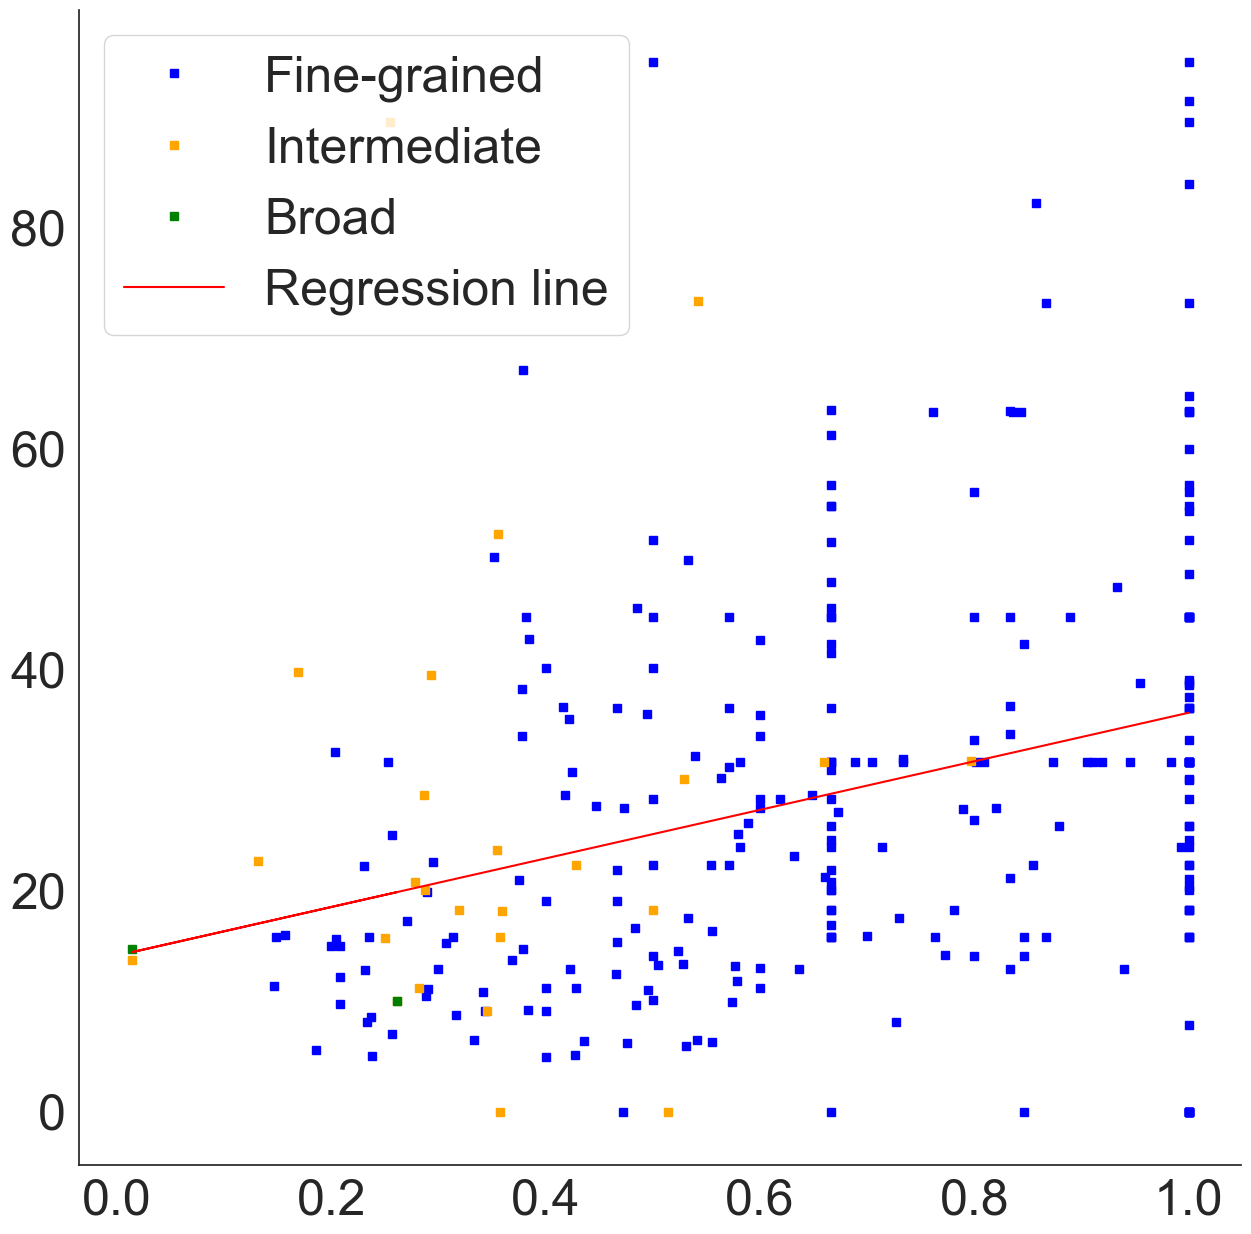

In [119]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats


tot_density_com_list=[]
tot_mflcc_list=[]
fine_grained_density_com_list=[]
fine_grained_mflcc_com_list=[]

for com,net_density in infomap_fine_grained_density_com_dict.items():
    lcczscore=fine_grained_communities_gomf_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        fine_grained_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_mflcc_list.append(lcczscore)
        fine_grained_mflcc_com_list.append(lcczscore)
 
middle_density_com_list=[]
middle_mflcc_com_list=[]
for com,net_density in infomap_middle_density_com_dict.items():
    lcczscore=middle_communities_gomf_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        middle_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_mflcc_list.append(lcczscore)
        middle_mflcc_com_list.append(lcczscore)
        
   
broad_density_com_list=[]
broad_mflcc_com_list=[]
for com,net_density in infomap_broad_density_com_dict.items():
    lcczscore=broad_communities_gomf_lcc_zscore[com]
    if str(lcczscore)!="nan" and str(lcczscore)!="inf":
        broad_density_com_list.append(net_density)
        tot_density_com_list.append(net_density)
        tot_mflcc_list.append(lcczscore)
        broad_mflcc_com_list.append(lcczscore)
        

    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(tot_density_com_list, tot_mflcc_list)

ax.plot(fine_grained_density_com_list,fine_grained_mflcc_com_list, linewidth=0, marker='s',c='blue', label='Fine-grained')
ax.plot(middle_density_com_list,middle_mflcc_com_list, linewidth=0, marker='s',c='orange', label='Intermediate')
ax.plot(broad_density_com_list,broad_mflcc_com_list, linewidth=0, marker='s',c='green', label='Broad')

y=[]
for i in tot_density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(tot_density_com_list, y,c='red', label=line)
#ax.set_xlabel('Average biological similarity', fontsize=18)
#ax.set_ylabel('Average chemical similarity',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Figures/SF19E.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [120]:
print(scipy.stats.pearsonr(tot_density_com_list, tot_mflcc_list))  # Pearson's r
print(scipy.stats.spearmanr(tot_density_com_list, tot_mflcc_list)) # Spearman's rho

PearsonRResult(statistic=0.31378467079246924, pvalue=6.257038303048721e-08)
SignificanceResult(statistic=0.35241782630837554, pvalue=9.308241916330827e-10)


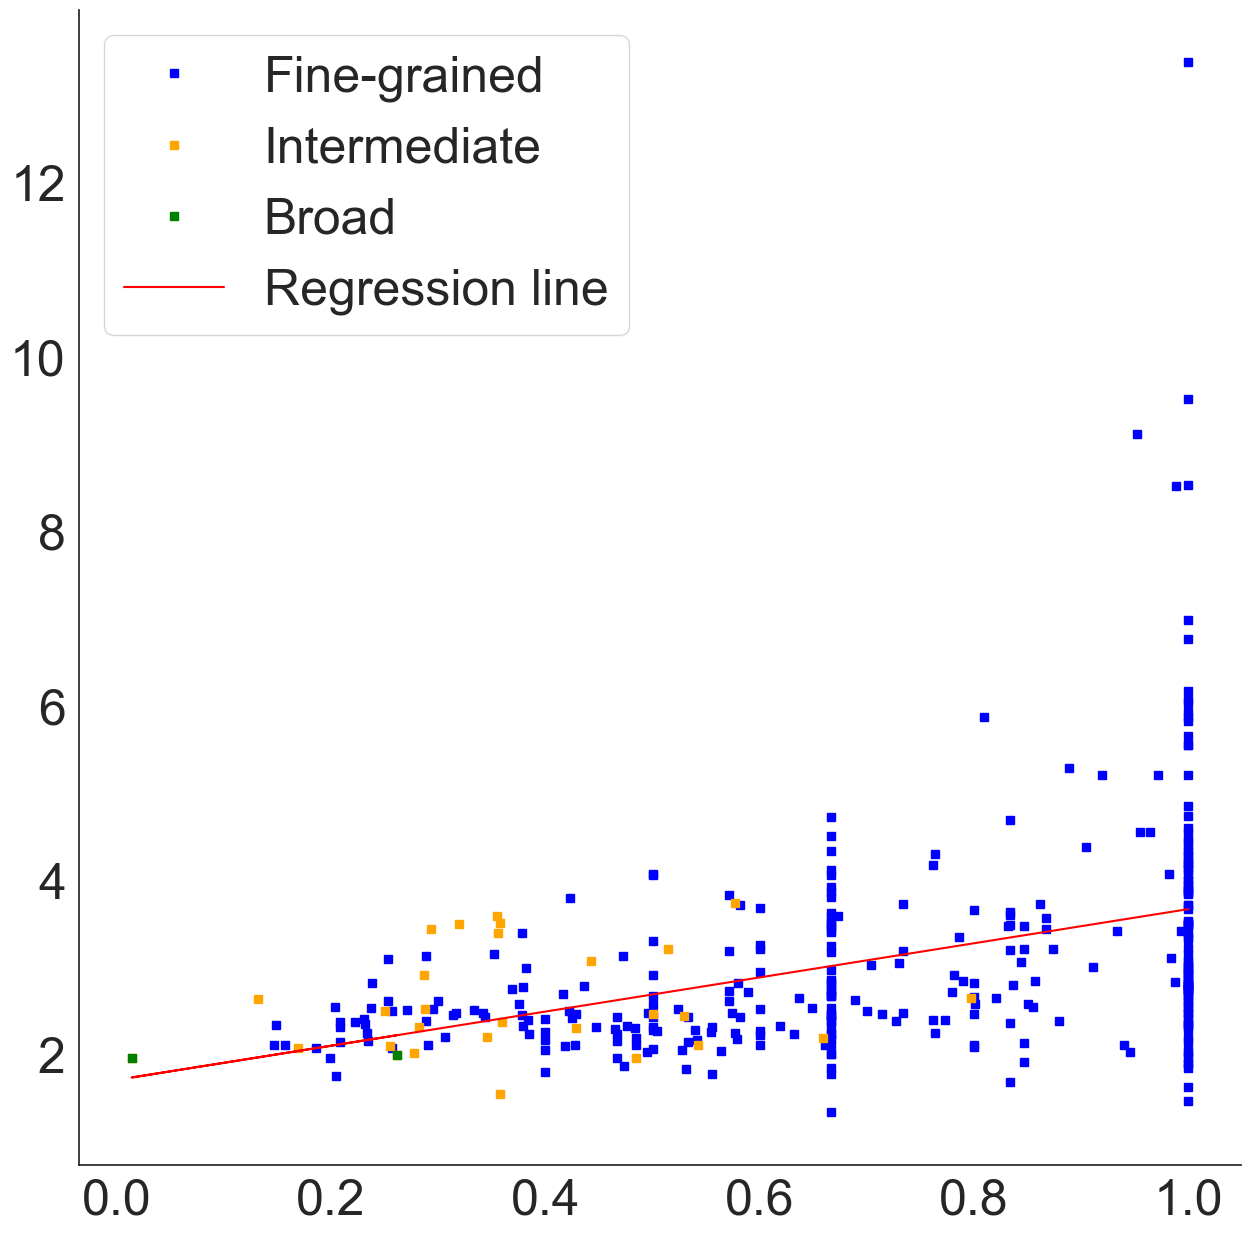

In [133]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats


tot_density_com_list=[]
tot_bpresnik_list=[]
fine_grained_density_com_list=[]
fine_grained_bpresnik_com_list=[]

for com,net_density in infomap_fine_grained_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in fine_grained_communities_gobp_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            fine_grained_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_bpresnik_list.append(np.mean(cl_resnik_list))
            fine_grained_bpresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
 
middle_density_com_list=[]
middle_bpresnik_com_list=[]

for com,net_density in infomap_middle_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in middle_communities_gobp_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            middle_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_bpresnik_list.append(np.mean(cl_resnik_list))
            middle_bpresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
   
broad_density_com_list=[]
broad_bpresnik_com_list=[]

for com,net_density in infomap_broad_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in broad_communities_gobp_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            broad_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_bpresnik_list.append(np.mean(cl_resnik_list))
            broad_bpresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
    
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(tot_density_com_list, tot_bpresnik_list)

ax.plot(fine_grained_density_com_list,fine_grained_bpresnik_com_list, linewidth=0, marker='s',c='blue', label='Fine-grained')
ax.plot(middle_density_com_list,middle_bpresnik_com_list, linewidth=0, marker='s',c='orange', label='Intermediate')
ax.plot(broad_density_com_list,broad_bpresnik_com_list, linewidth=0, marker='s',c='green', label='Broad')

y=[]
for i in tot_density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(tot_density_com_list, y,c='red', label=line)
#ax.set_xlabel('Network Density', fontsize=18)
#ax.set_ylabel('Resnik',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Figures/SF19F.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [134]:
print(scipy.stats.pearsonr(tot_density_com_list, tot_bpresnik_list))  # Pearson's r
print(scipy.stats.spearmanr(tot_density_com_list, tot_bpresnik_list)) # Spearman's rho

PearsonRResult(statistic=0.4174074038749999, pvalue=2.5801128560770737e-16)
SignificanceResult(statistic=0.4671866339642964, pvalue=1.539214639092767e-20)


/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


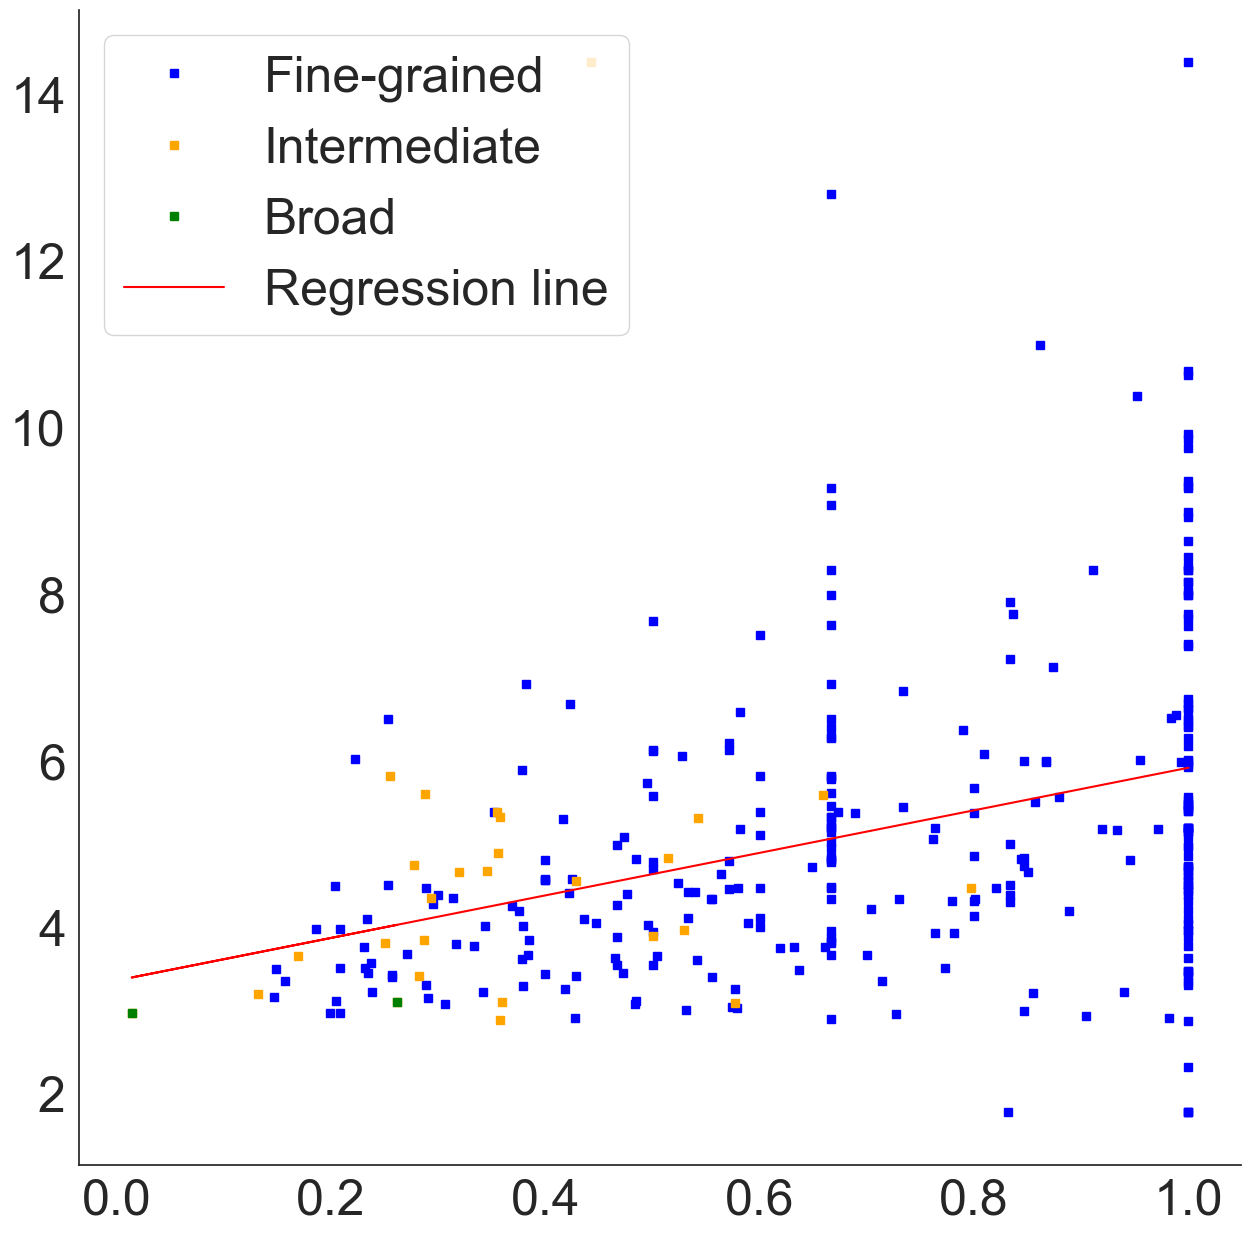

In [137]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats


tot_density_com_list=[]
tot_mfresnik_list=[]
fine_grained_density_com_list=[]
fine_grained_mfresnik_com_list=[]

for com,net_density in infomap_fine_grained_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in fine_grained_communities_gomf_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            fine_grained_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_mfresnik_list.append(np.mean(cl_resnik_list))
            fine_grained_mfresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
 
middle_density_com_list=[]
middle_mfresnik_com_list=[]

for com,net_density in infomap_middle_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in middle_communities_gomf_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            middle_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_mfresnik_list.append(np.mean(cl_resnik_list))
            middle_mfresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
   
broad_density_com_list=[]
broad_mfresnik_com_list=[]

for com,net_density in infomap_broad_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in broad_communities_gomf_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            broad_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_mfresnik_list.append(np.mean(cl_resnik_list))
            broad_mfresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
      
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(tot_density_com_list, tot_mfresnik_list)

ax.plot(fine_grained_density_com_list,fine_grained_mfresnik_com_list, linewidth=0, marker='s',c='blue', label='Fine-grained')
ax.plot(middle_density_com_list,middle_mfresnik_com_list, linewidth=0, marker='s',c='orange', label='Intermediate')
ax.plot(broad_density_com_list,broad_mfresnik_com_list, linewidth=0, marker='s',c='green', label='Broad')

y=[]
for i in tot_density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(tot_density_com_list, y,c='red', label=line)
#ax.set_xlabel('Network Density', fontsize=18)
#ax.set_ylabel('Resnik',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Figures/SF19G.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [138]:
print(scipy.stats.pearsonr(tot_density_com_list, tot_mfresnik_list))  # Pearson's r
print(scipy.stats.spearmanr(tot_density_com_list, tot_mfresnik_list)) # Spearman's rho

PearsonRResult(statistic=0.3703964267688086, pvalue=3.604839792085768e-12)
SignificanceResult(statistic=0.4145386403298482, pvalue=3.895115383697001e-15)


/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


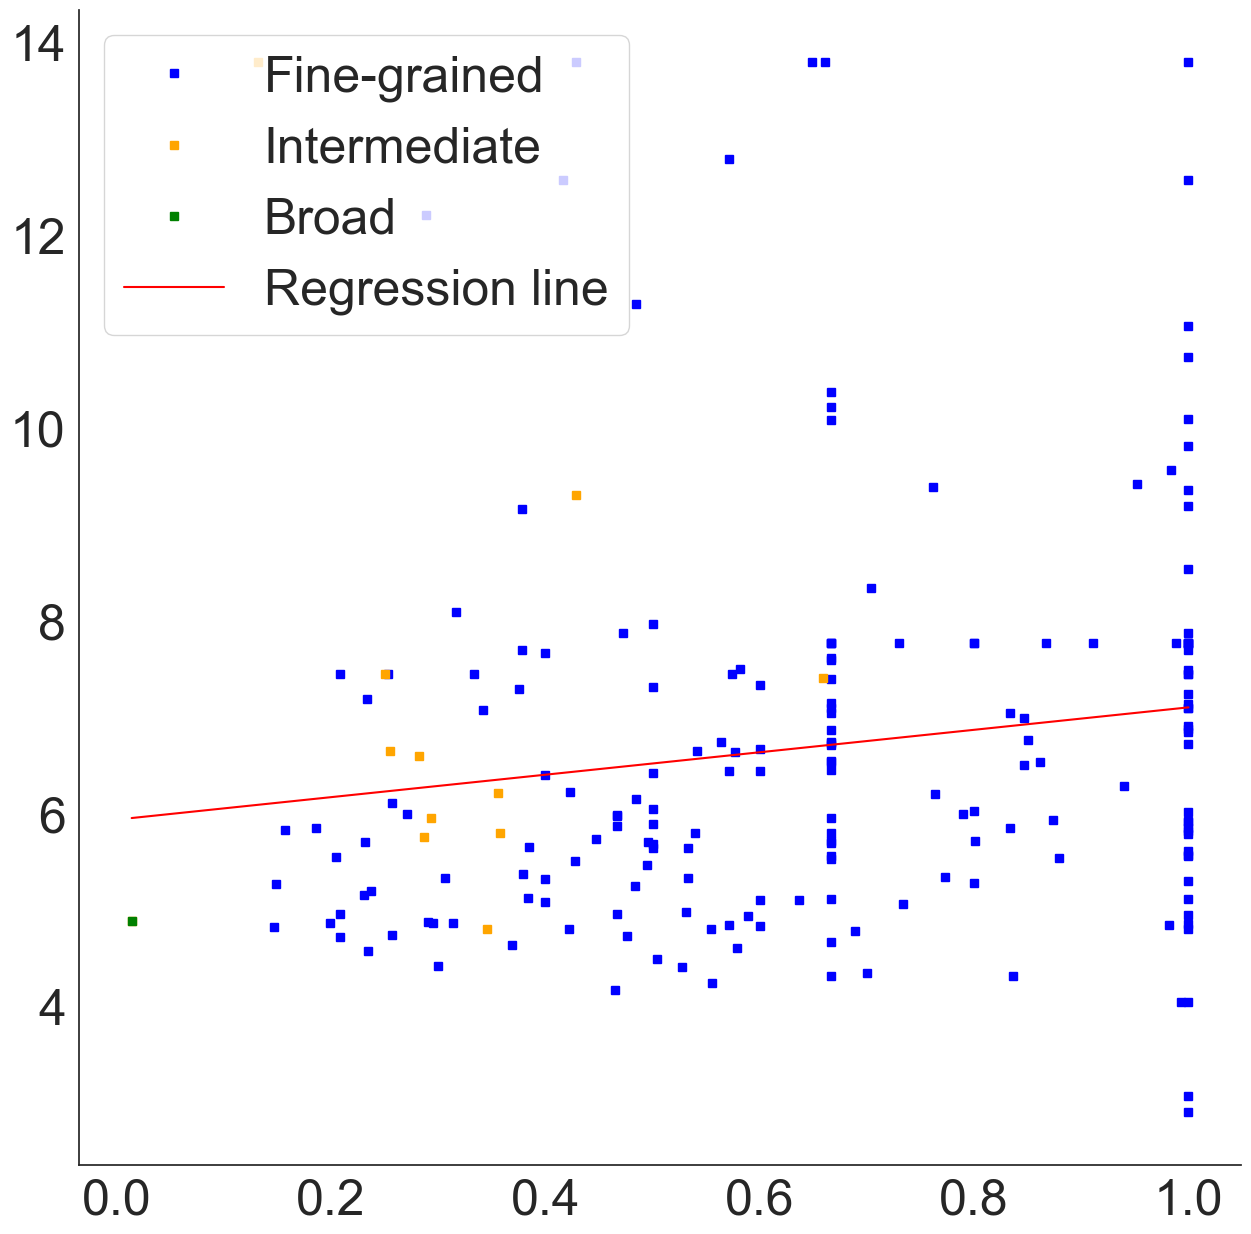

In [139]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats


tot_density_com_list=[]
tot_ccresnik_list=[]
fine_grained_density_com_list=[]
fine_grained_ccresnik_com_list=[]

for com,net_density in infomap_fine_grained_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in fine_grained_communities_gocc_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            fine_grained_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_ccresnik_list.append(np.mean(cl_resnik_list))
            fine_grained_ccresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
 
middle_density_com_list=[]
middle_ccresnik_com_list=[]

for com,net_density in infomap_middle_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in middle_communities_gocc_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            middle_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_ccresnik_list.append(np.mean(cl_resnik_list))
            middle_ccresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
       
broad_density_com_list=[]
broad_ccresnik_com_list=[]

for com,net_density in infomap_broad_density_com_dict.items():
    cl_resnik_list=[]
    try:
        for r in broad_communities_gocc_resnik[com]:
            if str(r)!="nan" and str(r)!="inf":
                cl_resnik_list.append(r)
        cl_resnik_list_mean=np.mean(cl_resnik_list)
        if str(cl_resnik_list_mean)!='nan':
            broad_density_com_list.append(net_density)
            tot_density_com_list.append(net_density)
            tot_ccresnik_list.append(np.mean(cl_resnik_list))
            broad_ccresnik_com_list.append(np.mean(cl_resnik_list))
    except:
        pass
      
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(tot_density_com_list, tot_ccresnik_list)

ax.plot(fine_grained_density_com_list,fine_grained_ccresnik_com_list, linewidth=0, marker='s',c='blue', label='Fine-grained')
ax.plot(middle_density_com_list,middle_ccresnik_com_list, linewidth=0, marker='s',c='orange', label='Intermediate')
ax.plot(broad_density_com_list,broad_ccresnik_com_list, linewidth=0, marker='s',c='green', label='Broad')

y=[]
for i in tot_density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(tot_density_com_list, y,c='red', label=line)
#ax.set_xlabel('Network Density', fontsize=18)
#ax.set_ylabel('Resnik',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Figures/SF19H.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [140]:
print(scipy.stats.pearsonr(tot_density_com_list, tot_ccresnik_list))  # Pearson's r
print(scipy.stats.spearmanr(tot_density_com_list, tot_ccresnik_list)) # Spearman's rho

PearsonRResult(statistic=0.1537518884583842, pvalue=0.02773353110930462)
SignificanceResult(statistic=0.23594331793231682, pvalue=0.0006598269372755595)


In [141]:
#Let's do it with a function for the gene ontology
def extract_unique_terms(hierarchical_community_enrichments):
    from collections import Counter
    lead_genes_all_terms=[]
    hierarchical_community_enrichments_only_unique_terms={}
    for com, gene_enr_list in hierarchical_community_enrichments.items():
        if type(gene_enr_list[1])==list:
            lead_genes_all_terms.extend(gene_enr_list[1])
    count_all_keggterms_enriched_dict=Counter(lead_genes_all_terms)
    for com, gene_enr_list in hierarchical_community_enrichments.items():
        unique_term_list=[]
        if type(gene_enr_list[1])==list:
            for term in gene_enr_list[1]:
                if count_all_keggterms_enriched_dict[term]==1:
                    unique_term_list.append(term)
        hierarchical_community_enrichments_only_unique_terms[com]=unique_term_list
        
    return hierarchical_community_enrichments_only_unique_terms

In [142]:
fine_grained_communities_kegg_unique=extract_unique_terms(fine_grained_communities_kegg)

In [143]:
middle_communities_kegg_uniqe=extract_unique_terms(middle_communities_kegg)

In [144]:
broad_communities_kegg_unique=extract_unique_terms(broad_communities_kegg)

Gene Part
===

In [98]:
final_backbone_gene_graph_significant_combo_df = pd.read_csv("output/final_backbone_gene_graph_significant_combo_ji_df.tsv", sep="\t",index_col=0)
backbone_ss_gene_network = nx.from_pandas_edgelist(final_backbone_gene_graph_significant_combo_df, 'Gene A', 'Gene B')


In [99]:
#from https://mapequation.github.io/infomap/python/infomap.html#infomap.InfomapIterator
#for some more examples on infomap: 
#https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=bd65c716de009b259e33715093fca7d27e06699b&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6368726973626c6f65636b65722f696e666f6d61702d6269706172746974652f626436356337313664653030396232353965333337313530393366636137643237653036363939622f6578616d706c65732f707974686f6e2f696e666f6d61702d6578616d706c65732e6970796e62&logged_in=false&nwo=chrisbloecker%2Finfomap-bipartite&path=examples%2Fpython%2Finfomap-examples.ipynb&platform=android&repository_id=176271675&repository_type=Repository&version=99


im = Infomap(silent=True)
mapping = im.add_networkx_graph(backbone_ss_gene_network)
im.run()


In [100]:
backbone_gene_node_com_dict={}
for node,modules in im.get_multilevel_modules(states=True).items():
    backbone_gene_node_com_dict[mapping[node]]=list(modules)


In [101]:
gg_first_iteration_infomap={}
gg_second_iteration_infomap={}
gg_third_iteration_infomap={}
gg_fourth_iteration_infomap={}

for com in set(im.get_modules(depth_level=1).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=1).items():
        if com==com1:
            node_list.append(mapping[node])
    gg_first_iteration_infomap[com]=node_list 
    
    
for com in set(im.get_modules(depth_level=2).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=2).items():
        if com==com1:
            node_list.append(mapping[node])
    gg_second_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=3).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=3).items():
        if com==com1:
            node_list.append(mapping[node])
    gg_third_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=4).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=4).items():
        if com==com1:
            node_list.append(mapping[node])
    gg_fourth_iteration_infomap[com]=node_list

In [102]:
len(gg_first_iteration_infomap)

76

In [103]:
len(gg_second_iteration_infomap)

479

In [104]:
len(gg_third_iteration_infomap)

485

In [105]:
len(gg_fourth_iteration_infomap)

485

In [106]:
with open('output/Communities/Infomap/gg_first_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(gg_first_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/gg_second_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(gg_second_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/gg_third_iteration_infomap.pickle', 'wb') as handle:
    pk.dump(gg_third_iteration_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)


In [107]:
#These communities are the middle and the broad level related to each community

gg_first_level_infomap={}  #middle to fine
for comcom, genelist1 in gg_second_iteration_infomap.items():
    comlist=[]
    for com, genelist2 in gg_third_iteration_infomap.items():
        if len(set(genelist1)&set(genelist2))==len(set(genelist2)):
           comlist.append(com)
    gg_first_level_infomap[comcom]=comlist

gg_second_level_infomap={}  #broad to middle
for comcom, genelist1 in gg_first_iteration_infomap.items():
    comlist=[]
    for com, genelist2 in gg_second_iteration_infomap.items():
        if len(set(genelist1)&set(genelist2))==len(set(genelist2)):
           comlist.append(com)
    gg_second_level_infomap[comcom]=comlist
 

In [108]:
with open('output/Communities/Infomap/gg_ji_first_infomap_iteration.pickle', 'wb') as handle:
    pk.dump(gg_first_level_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Infomap/gg_ji_second_infomap_iteration.pickle', 'wb') as handle:
    pk.dump(gg_second_level_infomap, handle, protocol=pk.HIGHEST_PROTOCOL)

In [156]:
#Let's try to associate some exposures or some chemical class to these communities
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass
#Here, we define the fisher test that we will use
def overlap_set_genes(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= len(background) #total number of exposures in chem_gene_cleaned
    n= len(set(setA))
    N= len(set(setB))
    x= len(set(setA).intersection(set(setB)))
    return str(stats.hypergeom.sf(x-1, M, n, N))


from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used



In [157]:
significant_gg_com_third_infomap_genes={}
for com,gene_set in gg_third_iteration_infomap.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_com_third_infomap_genes[com]= significant_chem_class
    
significant_gg_com_second_infomap_genes={}
for com,gene_set in gg_second_iteration_infomap.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_com_second_infomap_genes[com]= significant_chem_class
    
significant_gg_com_first_infomap_genes={}
for com,gene_set in gg_first_iteration_infomap.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_com_first_infomap_genes[com]= significant_chem_class
    
    

In [107]:
gg_first_second_infomap_division={}


for com1,nodelist1 in gg_first_iteration_infomap.items():
    com2_derived_list=[]
    for com2,nodelist2 in gg_second_iteration_infomap.items():
        if set(nodelist2).issubset(set(nodelist1))==True:
            com2_derived_list.append("B"+str(com2))
    gg_first_second_infomap_division["A"+str(com1)]=com2_derived_list

In [110]:
import numpy as np

com_color_dict={}
for com, com_derived_list in gg_first_second_infomap_division.items():
    color = 'rgba(%s,%s,%s, 0.8)' %(np.random.choice(range(256)),np.random.choice(range(256)),np.random.choice(range(256)))
    color_dervied=color.replace("0.8", str("0.4"))
    com_color_dict[com]=color
    for c in com_derived_list:
        com_color_dict[c]=color_dervied

        

In [118]:

com_label=[]
com_source_tot=[]
com_target_tot=[]
value_tot=[]
color_tot=[]
com_label_color=[]

for com_source,com_target_list in gg_first_iteration_infomap.items():
    com_label.append("A"+str(com_source))
    com_label_color.append(com_color_dict["A"+str(com_source)])
    

for com_source in gg_second_iteration_infomap.keys():
    com_label.append("B" + str(com_source))
    com_label_color.append(com_color_dict["B" + str(com_source)])
        
for com_source,com_target_list in gg_first_second_infomap_division.items():
    for c in com_target_list:
        com_source_tot.append(com_label.index(com_source))
        com_target_tot.append(com_label.index(c))
        pure_com_source=int(com_source[1:])
        pure_com_target=int(c[1:])
        intersection_set=set(gg_first_iteration_infomap[pure_com_source])&set(gg_second_iteration_infomap[pure_com_target])
        union_set=set(gg_first_iteration_infomap[pure_com_source]).union(set(gg_second_iteration_infomap[pure_com_target]))
        ji_index=len(intersection_set)/len(union_set)
        value_tot.append(ji_index)
        color_tot.append(com_color_dict[com_source])



In [120]:
import plotly.graph_objects as go
import kaleido



fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = com_label,
      color = com_label_color
    ),
    link = dict(
      source = com_source_tot, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = com_target_tot,
      value = value_tot,
      color = color_tot
        
  ))])

fig.update_layout(title_text="Infomap community evolution GGN", font_size=10)
fig.show()
fig.write_image("output/Communities/Infomap/GGN_infomap_communities.pdf", engine="kaleido")

In [125]:
#Let's try to associate some exposures or some chemical class to these communities
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass
#Here, we define the fisher test that we will use
def overlap_set_genes(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= len(background) #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))


from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used



In [150]:

    
significant_gg_com_first_infomap_exposures={}
for com,gene_set in gg_first_iteration_infomap.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_com_first_infomap_exposures[com]= significant_chem_class
    
significant_gg_com_second_infomap_exposures={}
for com,gene_set in gg_second_iteration_infomap.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_com_second_infomap_exposures[com]= significant_chem_class
    
    

In [151]:
for k,v in significant_gg_com_first_infomap_exposures.items():
    print(k,len(v))

1 3
2 5
3 3
4 5
5 9
6 26
7 18
8 6
9 8
10 42
11 2
12 8
13 3
14 2
15 12
16 4
17 5
18 10
19 1
20 1
21 2
22 1
23 2
24 1
25 3
26 3
27 2
28 1
29 7
30 3
31 7
32 1
33 3
34 2
35 0
36 1
37 2
38 1
39 3
40 1
41 7
42 2
43 5
44 2
45 4
46 1
47 2
48 1
49 2
50 3
51 3
52 1
53 1
54 1
55 1
56 3
57 4
58 2
59 2
60 0
61 1
62 4
63 4
64 2
65 4
66 1
67 0
68 1
69 2
70 1
71 0
72 1
73 0
74 0
75 3
76 0
77 1
78 0
79 0
80 3
81 1
82 2
83 2
84 0
85 0
86 1
87 0
88 0
89 0
90 0
91 2
92 14
93 0
94 0
95 0
96 2
97 1
98 4
99 1
100 0
101 3
102 2
103 2
104 2
105 2
106 0
107 2
108 0
109 3
110 3
111 0
112 0
113 0
114 1
115 0
116 105
117 0
118 0
119 1
120 0
121 3
122 0
123 3
124 0
125 0
126 2
127 65
128 0
129 0
130 0
131 0
132 37
133 0
134 0
135 0
136 2
137 1
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 1
148 50
149 0
150 2
151 10
152 0
153 8
154 64
155 3
156 0
157 0


In [154]:
significant_gg_com_first_infomap_exposures[61]

[['C018021', 0.04387514781575134]]

In [153]:

for k,v in significant_gg_com_first_infomap_exposures.items():
    for el in v:
        if el[0]=='C018021':
            print(k)

61


In [156]:
gg_first_iteration_infomap[61]

['RCP9',
 'CTAGE3P',
 'LRRC2-AS1',
 'PBP',
 'SAS10',
 'BLES03',
 'H41',
 'LYRIC',
 'SPG4',
 'MAN1',
 'SAMD4',
 'STARD6',
 'DCAF4L2',
 'OR14A16',
 'OR52B4',
 'CRA']

In [155]:
gg_first_second_infomap_division['A61']

['B68']

In [157]:
significant_gg_com_second_infomap_exposures[68]

[['C018021', 0.04387514781575134]]

In [187]:
#Let's run some biological enrichments


secondgen_gg_communities_infomap_kegg_enrichment={}
firstgen_gg_communities_infomap_kegg_enrichment={}
enrichment_libraries = ['KEGG_2021_Human']



import requests
import json
for com,genelist in gg_second_iteration_infomap.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    secondgen_gg_communities_infomap_kegg_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_first_iteration_infomap.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    firstgen_gg_communities_infomap_kegg_enrichment[com]=enriched_terms_specific_net
    


In [188]:
#Let's run some biological enrichments


secondgen_gg_communities_infomap_gobp_enrichment={}
firstgen_gg_communities_infomap_gobp_enrichment={}
enrichment_libraries = ['GO_Biological_Process_2021']



import requests
import json
for com,genelist in gg_second_iteration_infomap.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    secondgen_gg_communities_infomap_gobp_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_first_iteration_infomap.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    firstgen_gg_communities_infomap_gobp_enrichment[com]=enriched_terms_specific_net
    


In [189]:
#Let's run some biological enrichments


secondgen_gg_communities_infomap_gomf_enrichment={}
firstgen_gg_communities_infomap_gomf_enrichment={}
enrichment_libraries = ['GO_Molecular_Function_2021']



import requests
import json
for com,genelist in gg_second_iteration_infomap.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    secondgen_gg_communities_infomap_gomf_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_first_iteration_infomap.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    firstgen_gg_communities_infomap_gomf_enrichment[com]=enriched_terms_specific_net
    


In [190]:
#Let's run some biological enrichments


secondgen_gg_communities_infomap_gocc_enrichment={}
firstgen_gg_communities_infomap_gocc_enrichment={}
enrichment_libraries = ['GO_Cellular_Component_2021']



import requests
import json
for com,genelist in gg_second_iteration_infomap.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    secondgen_gg_communities_infomap_gocc_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_first_iteration_infomap.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    firstgen_gg_communities_infomap_gocc_enrichment[com]=enriched_terms_specific_net
    


In [191]:
with open('output/Communities/Infomap/secondgen_gg_communities_infomap_kegg_enrichment.pickle', 'wb') as handle:
    pk.dump(secondgen_gg_communities_infomap_kegg_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)
   
with open('output/Communities/Infomap/firstgen_gg_communities_infomap_kegg_enrichment.pickle', 'wb') as handle:
    pk.dump(firstgen_gg_communities_infomap_kegg_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/secondgen_gg_communities_infomap_gobp_enrichment.pickle', 'wb') as handle:
    pk.dump(secondgen_gg_communities_infomap_gobp_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/firstgen_gg_communities_infomap_gobp_enrichment.pickle', 'wb') as handle:
    pk.dump(firstgen_gg_communities_infomap_gobp_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)
   
with open('output/Communities/Infomap/secondgen_gg_communities_infomap_gomf_enrichment.pickle', 'wb') as handle:
    pk.dump(secondgen_gg_communities_infomap_gomf_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/firstgen_gg_communities_infomap_gomf_enrichment.pickle', 'wb') as handle:
    pk.dump(firstgen_gg_communities_infomap_gomf_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Infomap/secondgen_gg_communities_infomap_gocc_enrichment.pickle', 'wb') as handle:
    pk.dump(secondgen_gg_communities_infomap_gocc_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)
   
with open('output/Communities/Infomap/firstgen_gg_communities_infomap_gocc_enrichment.pickle', 'wb') as handle:
    pk.dump(firstgen_gg_communities_infomap_gocc_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

